In [1]:
# Import modules.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import fpgrowth
from mlxtend.frequent_patterns import association_rules
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.plotting import plot_confusion_matrix

from catboost import CatBoostClassifier, Pool

import warnings; warnings.filterwarnings('ignore')


# Set default asthetic parameters.
sns.set()

In [2]:
# Dataset downloaded from this website and saved to Olist_Dataset folder in Documents
#data_source = 'https://www.kaggle.com/olistbr/brazilian-ecommerce'

# Load orders dataset.
orders = pd.read_csv(r"C:\Users\KSAIJ\Documents\Data Projects\Market Basket Analysis\Olist_Dataset\olist_order_items_dataset.csv")


# Load products items dataset.
products = pd.read_csv(r"C:\Users\KSAIJ\Documents\Data Projects\Market Basket Analysis\Olist_Dataset\olist_products_dataset.csv")

# Load translations dataset.
translations = pd.read_csv(r"C:\Users\KSAIJ\Documents\Data Projects\Market Basket Analysis\Olist_Dataset\product_category_name_translation.csv")

In [3]:
# Print orders header.
orders.head()

order_id  order_item_id  \
0  00010242fe8c5a6d1ba2dd792cb16214              1   
1  00018f77f2f0320c557190d7a144bdd3              1   
2  000229ec398224ef6ca0657da4fc703e              1   
3  00024acbcdf0a6daa1e931b038114c75              1   
4  00042b26cf59d7ce69dfabb4e55b4fd9              1   

                         product_id                         seller_id  \
0  4244733e06e7ecb4970a6e2683c13e61  48436dade18ac8b2bce089ec2a041202   
1  e5f2d52b802189ee658865ca93d83a8f  dd7ddc04e1b6c2c614352b383efe2d36   
2  c777355d18b72b67abbeef9df44fd0fd  5b51032eddd242adc84c38acab88f23d   
3  7634da152a4610f1595efa32f14722fc  9d7a1d34a5052409006425275ba1c2b4   
4  ac6c3623068f30de03045865e4e10089  df560393f3a51e74553ab94004ba5c87   

  shipping_limit_date   price  freight_value  
0     2017-09-19 9:45   58.90          13.29  
1    2017-05-03 11:05  239.90          19.93  
2    2018-01-18 14:48  199.00          17.87  
3    2018-08-15 10:10   12.99          12.79  
4    2017-02-13 13:57  199.90          18.14

In [4]:
# Print orders info.
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   order_id             112650 non-null  object 
 1   order_item_id        112650 non-null  int64  
 2   product_id           112650 non-null  object 
 3   seller_id            112650 non-null  object 
 4   shipping_limit_date  112650 non-null  object 
 5   price                112650 non-null  float64
 6   freight_value        112650 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 6.0+ MB


In [5]:
# Print products header.
products.head()

product_id  product_category_name  \
0  1e9e8ef04dbcff4541ed26657ea517e5             perfumaria   
1  3aa071139cb16b67ca9e5dea641aaa2f                  artes   
2  96bd76ec8810374ed1b65e291975717f          esporte_lazer   
3  cef67bcfe19066a932b7673e239eb23d                  bebes   
4  9dc1a7de274444849c219cff195d0b71  utilidades_domesticas   

   product_name_lenght  product_description_lenght  product_photos_qty  \
0                 40.0                       287.0                 1.0   
1                 44.0                       276.0                 1.0   
2                 46.0                       250.0                 1.0   
3                 27.0                       261.0                 1.0   
4                 37.0                       402.0                 4.0   

   product_weight_g  product_length_cm  product_height_cm  product_width_cm  
0             225.0               16.0               10.0              14.0  
1            1000.0               30.0               18.0              20.0  
2             154.0               18.0                9.0              15.0  
3             371.0               26.0                4.0              26.0  
4             625.0               20.0               17.0              13.0

In [6]:
# Print products info.
products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32951 entries, 0 to 32950
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   product_id                  32951 non-null  object 
 1   product_category_name       32341 non-null  object 
 2   product_name_lenght         32341 non-null  float64
 3   product_description_lenght  32341 non-null  float64
 4   product_photos_qty          32341 non-null  float64
 5   product_weight_g            32949 non-null  float64
 6   product_length_cm           32949 non-null  float64
 7   product_height_cm           32949 non-null  float64
 8   product_width_cm            32949 non-null  float64
dtypes: float64(7), object(2)
memory usage: 2.3+ MB


In [7]:
# Print translations header.
translations.head()

product_category_name product_category_name_english
0            beleza_saude                 health_beauty
1  informatica_acessorios         computers_accessories
2              automotivo                          auto
3         cama_mesa_banho                bed_bath_table
4        moveis_decoracao               furniture_decor

In [8]:
# Print translations info.
translations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71 entries, 0 to 70
Data columns (total 2 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   product_category_name          71 non-null     object
 1   product_category_name_english  71 non-null     object
dtypes: object(2)
memory usage: 1.2+ KB


The product names are given in Portuguese, so translations DataFrame is created to translate the names to English.


In [9]:
# Translate product names to English.
products = products.merge(translations, on='product_category_name', how="left")

# Print English names.
products['product_category_name_english']

0                        perfumery
1                              art
2                   sports_leisure
3                             baby
4                       housewares
                   ...            
32946              furniture_decor
32947    construction_tools_lights
32948               bed_bath_table
32949        computers_accessories
32950               bed_bath_table
Name: product_category_name_english, Length: 32951, dtype: object

In [10]:
products.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32951 entries, 0 to 32950
Data columns (total 10 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   product_id                     32951 non-null  object 
 1   product_category_name          32341 non-null  object 
 2   product_name_lenght            32341 non-null  float64
 3   product_description_lenght     32341 non-null  float64
 4   product_photos_qty             32341 non-null  float64
 5   product_weight_g               32949 non-null  float64
 6   product_length_cm              32949 non-null  float64
 7   product_height_cm              32949 non-null  float64
 8   product_width_cm               32949 non-null  float64
 9   product_category_name_english  32328 non-null  object 
dtypes: float64(7), object(3)
memory usage: 2.8+ MB


In [11]:
products.isnull().sum()

product_id                         0
product_category_name            610
product_name_lenght              610
product_description_lenght       610
product_photos_qty               610
product_weight_g                   2
product_length_cm                  2
product_height_cm                  2
product_width_cm                   2
product_category_name_english    623
dtype: int64

As product names are not available, converting product IDs to product category names will simplify the analysis, since there are fewer categories than products.

In [12]:
# Define product category name in orders DataFrame.
orders = orders.merge(products[['product_id','product_category_name_english']], on='product_id', how='left')

In [13]:
# Print orders header.
orders.head()

order_id  order_item_id  \
0  00010242fe8c5a6d1ba2dd792cb16214              1   
1  00018f77f2f0320c557190d7a144bdd3              1   
2  000229ec398224ef6ca0657da4fc703e              1   
3  00024acbcdf0a6daa1e931b038114c75              1   
4  00042b26cf59d7ce69dfabb4e55b4fd9              1   

                         product_id                         seller_id  \
0  4244733e06e7ecb4970a6e2683c13e61  48436dade18ac8b2bce089ec2a041202   
1  e5f2d52b802189ee658865ca93d83a8f  dd7ddc04e1b6c2c614352b383efe2d36   
2  c777355d18b72b67abbeef9df44fd0fd  5b51032eddd242adc84c38acab88f23d   
3  7634da152a4610f1595efa32f14722fc  9d7a1d34a5052409006425275ba1c2b4   
4  ac6c3623068f30de03045865e4e10089  df560393f3a51e74553ab94004ba5c87   

  shipping_limit_date   price  freight_value product_category_name_english  
0     2017-09-19 9:45   58.90          13.29                    cool_stuff  
1    2017-05-03 11:05  239.90          19.93                      pet_shop  
2    2018-01-18 14:48  199.00          17.87               furniture_decor  
3    2018-08-15 10:10   12.99          12.79                     perfumery  
4    2017-02-13 13:57  199.90          18.14                  garden_tools

In [14]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 112650 entries, 0 to 112649
Data columns (total 8 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   order_id                       112650 non-null  object 
 1   order_item_id                  112650 non-null  int64  
 2   product_id                     112650 non-null  object 
 3   seller_id                      112650 non-null  object 
 4   shipping_limit_date            112650 non-null  object 
 5   price                          112650 non-null  float64
 6   freight_value                  112650 non-null  float64
 7   product_category_name_english  111023 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 7.7+ MB


In [15]:
orders.isnull().sum()

order_id                            0
order_item_id                       0
product_id                          0
seller_id                           0
shipping_limit_date                 0
price                               0
freight_value                       0
product_category_name_english    1627
dtype: int64

In [16]:
## NaN values as % of total observations
orders.isnull().sum()*100/len(orders)

order_id                         0.000000
order_item_id                    0.000000
product_id                       0.000000
seller_id                        0.000000
shipping_limit_date              0.000000
price                            0.000000
freight_value                    0.000000
product_category_name_english    1.444296
dtype: float64

In [17]:
# Drop products without a defined category.
orders.dropna(inplace=True, subset=['product_category_name_english'])

In [18]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 111023 entries, 0 to 112649
Data columns (total 8 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   order_id                       111023 non-null  object 
 1   order_item_id                  111023 non-null  int64  
 2   product_id                     111023 non-null  object 
 3   seller_id                      111023 non-null  object 
 4   shipping_limit_date            111023 non-null  object 
 5   price                          111023 non-null  float64
 6   freight_value                  111023 non-null  float64
 7   product_category_name_english  111023 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 7.6+ MB


In [19]:
orders.drop(['seller_id', 'shipping_limit_date', 'freight_value'], axis=1, inplace=True)

In [20]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 111023 entries, 0 to 112649
Data columns (total 5 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   order_id                       111023 non-null  object 
 1   order_item_id                  111023 non-null  int64  
 2   product_id                     111023 non-null  object 
 3   price                          111023 non-null  float64
 4   product_category_name_english  111023 non-null  object 
dtypes: float64(1), int64(1), object(3)
memory usage: 5.1+ MB


In [21]:
# Print number of unique items.
len(orders['product_id'].unique())

32328

In [22]:
# Print number of unique categories.
len(orders['product_category_name_english'].unique())

71

Performing "aggregation" up to the product category level reduces the number of potential itemsets from 2(e32328) to 2(e71).

I will perform Market Basket Analysis on transactions. A transaction consists of the unique items purchased by a customer.
Extract transactions from orders DataFrame using groupby all items in an order and list of unique values.

In [23]:
# Recover transaction itemsets from orders DataFrame.
transactions = orders.groupby("order_id").product_category_name_english.unique()

# Print transactions header.
transactions.head()

order_id
00010242fe8c5a6d1ba2dd792cb16214         [cool_stuff]
00018f77f2f0320c557190d7a144bdd3           [pet_shop]
000229ec398224ef6ca0657da4fc703e    [furniture_decor]
00024acbcdf0a6daa1e931b038114c75          [perfumery]
00042b26cf59d7ce69dfabb4e55b4fd9       [garden_tools]
Name: product_category_name_english, dtype: object

In [24]:
type(transactions)

pandas.core.series.Series

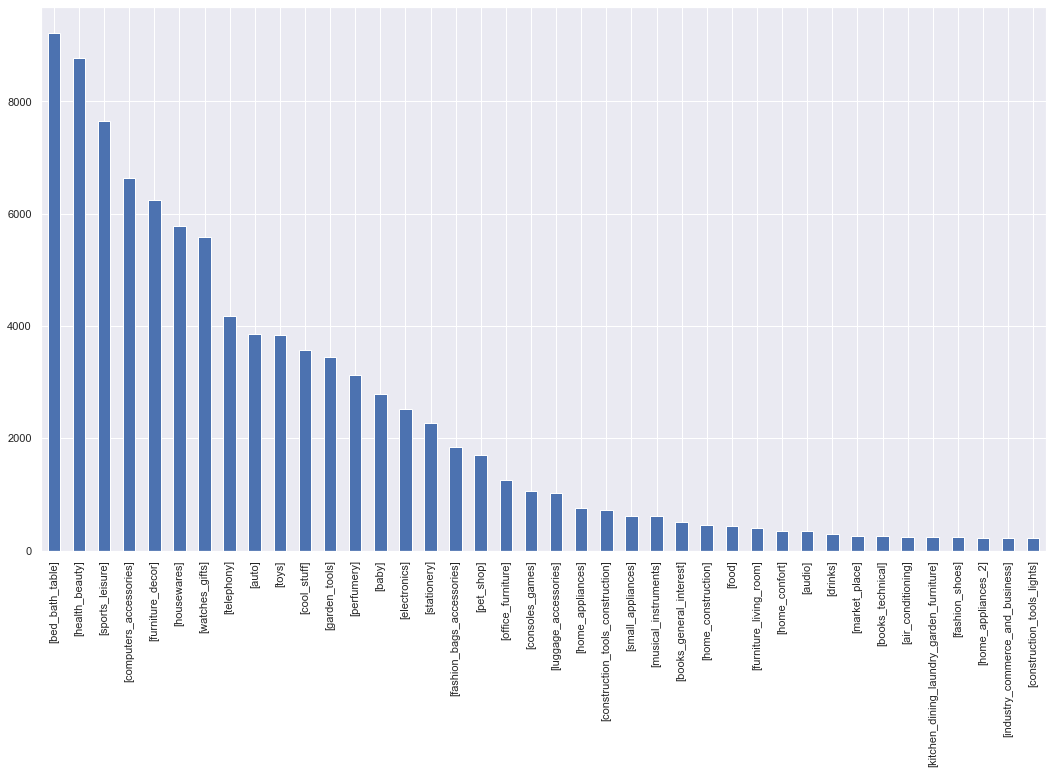

In [25]:
# Plot 40 largest categories of transactions.
transactions.value_counts()[:40].plot(kind='bar', figsize=(18,10))

In [26]:
len(transactions)

97256

In [27]:
 # Count number of unique item categories for each transaction.
counts = [len(transaction) for transaction in transactions]

In [28]:
# Print maximum number of items in a transaction.
np.max(counts)

3

In [29]:
transactions = list(transactions)

In [30]:
print(*transactions, sep = ", ")

['cool_stuff'], ['pet_shop'], ['furniture_decor'], ['perfumery'], ['garden_tools'], ['housewares'], ['telephony'], ['garden_tools'], ['health_beauty'], ['books_technical'], ['health_beauty'], ['fashion_bags_accessories'], ['bed_bath_table'], ['garden_tools'], ['sports_leisure'], ['consoles_games'], ['perfumery'], ['sports_leisure'], ['cool_stuff'], ['bed_bath_table'], ['telephony'], ['office_furniture'], ['fashion_bags_accessories'], ['cool_stuff'], ['sports_leisure'], ['luggage_accessories'], ['furniture_decor'], ['food'], ['furniture_decor'], ['agro_industry_and_commerce'], ['furniture_decor'], ['sports_leisure'], ['telephony'], ['electronics'], ['bed_bath_table'], ['garden_tools'], ['computers_accessories'], ['cool_stuff'], ['furniture_decor'], ['electronics'], ['construction_tools_construction'], ['computers_accessories'], ['bed_bath_table'], ['health_beauty'], ['pet_shop'], ['bed_bath_table'], ['computers_accessories'], ['health_beauty'], ['furniture_decor'], ['furniture_decor'], 

['computers_accessories'], ['pet_shop'], ['electronics'], ['baby'], ['watches_gifts'], ['cool_stuff'], ['auto'], ['office_furniture'], ['bed_bath_table'], ['books_technical'], ['housewares'], ['garden_tools'], ['sports_leisure'], ['garden_tools'], ['garden_tools'], ['luggage_accessories'], ['sports_leisure'], ['watches_gifts'], ['perfumery'], ['sports_leisure'], ['garden_tools'], ['home_confort'], ['furniture_decor'], ['construction_tools_safety'], ['housewares'], ['computers_accessories'], ['computers_accessories'], ['furniture_decor' 'musical_instruments'], ['luggage_accessories'], ['health_beauty'], ['housewares'], ['cool_stuff'], ['computers_accessories'], ['stationery'], ['watches_gifts'], ['housewares'], ['baby'], ['housewares'], ['housewares'], ['sports_leisure'], ['watches_gifts'], ['stationery'], ['furniture_decor'], ['cool_stuff'], ['fashion_bags_accessories'], ['computers_accessories'], ['watches_gifts'], ['office_furniture'], ['office_furniture'], ['computers_accessories'],

['home_appliances'], ['sports_leisure'], ['health_beauty'], ['bed_bath_table'], ['housewares'], ['perfumery'], ['auto'], ['furniture_decor'], ['health_beauty'], ['watches_gifts'], ['consoles_games'], ['telephony'], ['garden_tools'], ['musical_instruments'], ['watches_gifts'], ['sports_leisure'], ['bed_bath_table'], ['furniture_decor'], ['office_furniture'], ['health_beauty'], ['health_beauty'], ['watches_gifts'], ['agro_industry_and_commerce'], ['watches_gifts'], ['sports_leisure'], ['musical_instruments'], ['computers_accessories'], ['bed_bath_table'], ['construction_tools_lights'], ['auto'], ['telephony'], ['computers_accessories'], ['health_beauty'], ['sports_leisure'], ['sports_leisure'], ['furniture_decor'], ['luggage_accessories'], ['computers_accessories'], ['bed_bath_table'], ['bed_bath_table'], ['furniture_decor'], ['stationery'], ['toys'], ['furniture_decor'], ['garden_tools'], ['furniture_decor'], ['health_beauty'], ['sports_leisure'], ['books_general_interest'], ['sports_le

['sports_leisure'], ['health_beauty'], ['health_beauty'], ['furniture_decor'], ['auto'], ['food'], ['housewares'], ['cool_stuff'], ['home_appliances_2'], ['watches_gifts'], ['sports_leisure'], ['watches_gifts'], ['housewares'], ['computers_accessories'], ['housewares'], ['health_beauty'], ['cool_stuff'], ['pet_shop'], ['watches_gifts'], ['electronics'], ['toys'], ['cool_stuff'], ['garden_tools'], ['telephony'], ['health_beauty'], ['fashion_bags_accessories'], ['electronics'], ['sports_leisure'], ['perfumery'], ['telephony'], ['musical_instruments'], ['furniture_decor'], ['housewares'], ['pet_shop'], ['books_general_interest'], ['electronics'], ['health_beauty'], ['perfumery'], ['computers_accessories'], ['books_general_interest'], ['fashion_bags_accessories'], ['furniture_decor'], ['health_beauty'], ['auto'], ['luggage_accessories'], ['bed_bath_table'], ['bed_bath_table'], ['furniture_decor'], ['pet_shop'], ['electronics'], ['food'], ['computers_accessories'], ['housewares'], ['compute

['office_furniture'], ['bed_bath_table'], ['garden_tools'], ['garden_tools'], ['health_beauty'], ['furniture_decor'], ['pet_shop'], ['toys'], ['office_furniture'], ['garden_tools'], ['housewares'], ['stationery'], ['telephony'], ['telephony'], ['sports_leisure'], ['furniture_decor'], ['toys'], ['office_furniture'], ['health_beauty'], ['cool_stuff'], ['housewares'], ['sports_leisure'], ['telephony'], ['health_beauty'], ['baby'], ['bed_bath_table'], ['toys'], ['baby'], ['furniture_decor'], ['cool_stuff'], ['furniture_decor'], ['furniture_decor'], ['sports_leisure'], ['telephony'], ['health_beauty'], ['bed_bath_table'], ['cool_stuff'], ['perfumery'], ['garden_tools' 'computers_accessories'], ['computers_accessories'], ['bed_bath_table'], ['housewares'], ['computers_accessories'], ['garden_tools'], ['perfumery'], ['sports_leisure'], ['computers_accessories'], ['computers_accessories'], ['watches_gifts'], ['agro_industry_and_commerce'], ['sports_leisure'], ['watches_gifts'], ['home_applianc

['watches_gifts'], ['computers_accessories'], ['furniture_decor'], ['perfumery'], ['sports_leisure'], ['telephony'], ['health_beauty'], ['sports_leisure'], ['bed_bath_table'], ['toys'], ['housewares'], ['housewares'], ['computers_accessories'], ['sports_leisure'], ['health_beauty'], ['sports_leisure'], ['electronics'], ['watches_gifts' 'sports_leisure'], ['pet_shop'], ['toys'], ['industry_commerce_and_business'], ['cool_stuff'], ['sports_leisure'], ['computers_accessories'], ['auto'], ['perfumery'], ['computers_accessories'], ['computers_accessories'], ['home_appliances'], ['housewares'], ['garden_tools'], ['housewares'], ['garden_tools'], ['bed_bath_table'], ['furniture_decor'], ['perfumery'], ['computers_accessories'], ['stationery'], ['electronics'], ['housewares'], ['home_appliances_2'], ['bed_bath_table'], ['sports_leisure'], ['cool_stuff'], ['pet_shop'], ['auto'], ['housewares'], ['health_beauty'], ['computers_accessories'], ['sports_leisure'], ['computers_accessories'], ['bed_ba

['baby'], ['garden_tools'], ['watches_gifts'], ['telephony'], ['stationery'], ['sports_leisure'], ['bed_bath_table'], ['fashion_bags_accessories'], ['furniture_decor'], ['perfumery'], ['bed_bath_table'], ['costruction_tools_garden'], ['pet_shop'], ['housewares'], ['home_appliances'], ['food'], ['bed_bath_table'], ['stationery'], ['auto'], ['toys'], ['perfumery'], ['watches_gifts'], ['furniture_decor'], ['industry_commerce_and_business'], ['housewares'], ['health_beauty'], ['bed_bath_table'], ['office_furniture'], ['construction_tools_lights'], ['health_beauty'], ['electronics'], ['bed_bath_table'], ['computers_accessories'], ['housewares'], ['furniture_decor'], ['furniture_decor'], ['office_furniture'], ['bed_bath_table'], ['telephony'], ['housewares'], ['signaling_and_security'], ['bed_bath_table'], ['garden_tools' 'construction_tools_construction'], ['auto'], ['computers_accessories'], ['kitchen_dining_laundry_garden_furniture'], ['auto'], ['furniture_decor'], ['stationery'], ['bed_b

, ['housewares'], ['housewares'], ['stationery'], ['construction_tools_lights'], ['health_beauty'], ['bed_bath_table'], ['food_drink'], ['luggage_accessories'], ['sports_leisure'], ['baby'], ['auto'], ['bed_bath_table'], ['watches_gifts'], ['garden_tools'], ['computers_accessories'], ['health_beauty'], ['watches_gifts'], ['sports_leisure'], ['watches_gifts'], ['housewares'], ['watches_gifts'], ['auto'], ['fashion_bags_accessories'], ['watches_gifts'], ['sports_leisure'], ['bed_bath_table'], ['watches_gifts'], ['agro_industry_and_commerce'], ['health_beauty'], ['sports_leisure'], ['construction_tools_safety'], ['office_furniture'], ['food_drink'], ['perfumery'], ['signaling_and_security'], ['bed_bath_table'], ['garden_tools'], ['baby'], ['industry_commerce_and_business'], ['telephony'], ['bed_bath_table'], ['computers_accessories'], ['computers_accessories'], ['stationery'], ['electronics'], ['watches_gifts'], ['sports_leisure'], ['housewares'], ['perfumery'], ['auto'], ['telephony'], [

, ['auto'], ['perfumery'], ['health_beauty'], ['health_beauty'], ['furniture_decor'], ['computers_accessories'], ['health_beauty'], ['bed_bath_table'], ['consoles_games'], ['bed_bath_table'], ['auto'], ['pet_shop'], ['furniture_decor'], ['stationery'], ['auto'], ['electronics'], ['cool_stuff'], ['watches_gifts'], ['bed_bath_table'], ['watches_gifts'], ['small_appliances'], ['watches_gifts'], ['sports_leisure'], ['housewares'], ['housewares'], ['sports_leisure'], ['housewares'], ['cool_stuff'], ['housewares' 'small_appliances'], ['health_beauty'], ['bed_bath_table'], ['bed_bath_table'], ['perfumery'], ['garden_tools'], ['furniture_decor'], ['health_beauty'], ['garden_tools'], ['baby'], ['perfumery'], ['home_appliances'], ['toys'], ['sports_leisure'], ['small_appliances'], ['watches_gifts'], ['telephony'], ['health_beauty'], ['perfumery'], ['bed_bath_table'], ['housewares'], ['sports_leisure'], ['health_beauty'], ['home_appliances'], ['musical_instruments'], ['health_beauty'], ['telephon

, ['perfumery'], ['computers_accessories'], ['telephony'], ['costruction_tools_garden'], ['telephony'], ['home_comfort_2'], ['perfumery'], ['perfumery'], ['housewares'], ['housewares'], ['housewares'], ['furniture_decor'], ['health_beauty'], ['furniture_decor'], ['fashion_shoes'], ['consoles_games'], ['furniture_decor'], ['construction_tools_construction'], ['health_beauty'], ['garden_tools'], ['watches_gifts'], ['bed_bath_table'], ['toys'], ['furniture_decor'], ['toys'], ['baby'], ['baby'], ['housewares'], ['baby'], ['consoles_games'], ['watches_gifts'], ['baby'], ['small_appliances'], ['auto'], ['computers_accessories'], ['computers_accessories'], ['electronics'], ['perfumery'], ['luggage_accessories'], ['bed_bath_table'], ['bed_bath_table'], ['housewares'], ['toys'], ['perfumery'], ['home_appliances'], ['housewares'], ['auto'], ['baby'], ['fashion_bags_accessories'], ['furniture_decor'], ['home_appliances'], ['consoles_games'], ['garden_tools'], ['auto'], ['telephony'], ['health_bea

['consoles_games'], ['sports_leisure'], ['watches_gifts'], ['fashion_bags_accessories' 'auto' 'musical_instruments'], ['computers_accessories'], ['furniture_decor'], ['telephony'], ['furniture_decor'], ['computers_accessories'], ['watches_gifts'], ['sports_leisure'], ['industry_commerce_and_business'], ['electronics'], ['electronics'], ['watches_gifts'], ['cool_stuff'], ['telephony'], ['stationery'], ['baby'], ['bed_bath_table'], ['housewares'], ['health_beauty'], ['bed_bath_table'], ['housewares'], ['sports_leisure'], ['health_beauty'], ['computers_accessories'], ['fashion_bags_accessories'], ['bed_bath_table'], ['music'], ['office_furniture'], ['computers_accessories'], ['sports_leisure'], ['furniture_decor'], ['furniture_decor'], ['furniture_decor'], ['watches_gifts'], ['health_beauty'], ['home_appliances_2'], ['sports_leisure'], ['garden_tools'], ['garden_tools'], ['auto'], ['bed_bath_table'], ['perfumery'], ['home_confort'], ['baby'], ['sports_leisure'], ['sports_leisure'], ['heal

['sports_leisure'], ['telephony'], ['luggage_accessories'], ['housewares'], ['bed_bath_table'], ['consoles_games'], ['bed_bath_table'], ['cool_stuff'], ['furniture_living_room'], ['toys'], ['toys'], ['telephony'], ['construction_tools_construction'], ['auto'], ['agro_industry_and_commerce'], ['bed_bath_table'], ['perfumery'], ['consoles_games'], ['furniture_decor'], ['cool_stuff'], ['bed_bath_table'], ['watches_gifts'], ['watches_gifts'], ['fashion_bags_accessories'], ['watches_gifts'], ['auto'], ['housewares'], ['computers_accessories'], ['bed_bath_table'], ['bed_bath_table'], ['auto'], ['luggage_accessories'], ['furniture_decor'], ['perfumery'], ['auto'], ['fashion_underwear_beach'], ['fixed_telephony'], ['home_construction'], ['garden_tools'], ['bed_bath_table'], ['cool_stuff'], ['housewares'], ['telephony'], ['health_beauty'], ['bed_bath_table'], ['health_beauty'], ['musical_instruments'], ['health_beauty'], ['stationery'], ['watches_gifts'], ['garden_tools'], ['garden_tools'], ['w

, ['perfumery'], ['construction_tools_construction'], ['furniture_living_room'], ['bed_bath_table'], ['books_technical'], ['watches_gifts'], ['furniture_decor'], ['bed_bath_table'], ['housewares'], ['furniture_decor'], ['consoles_games'], ['construction_tools_construction'], ['garden_tools'], ['sports_leisure'], ['construction_tools_construction'], ['furniture_decor'], ['health_beauty'], ['telephony'], ['baby'], ['watches_gifts'], ['cool_stuff'], ['furniture_decor'], ['watches_gifts'], ['home_appliances'], ['bed_bath_table'], ['health_beauty'], ['sports_leisure'], ['health_beauty'], ['garden_tools'], ['sports_leisure'], ['bed_bath_table'], ['auto'], ['housewares'], ['sports_leisure'], ['baby'], ['books_technical'], ['watches_gifts'], ['housewares'], ['furniture_decor'], ['bed_bath_table'], ['perfumery'], ['housewares'], ['health_beauty'], ['health_beauty'], ['bed_bath_table'], ['bed_bath_table'], ['health_beauty'], ['furniture_decor'], ['furniture_decor'], ['telephony'], ['health_beaut

, ['small_appliances_home_oven_and_coffee'], ['computers_accessories'], ['computers_accessories'], ['baby'], ['watches_gifts'], ['watches_gifts'], ['musical_instruments'], ['pet_shop'], ['office_furniture'], ['furniture_decor'], ['bed_bath_table'], ['computers_accessories'], ['watches_gifts'], ['bed_bath_table'], ['watches_gifts'], ['housewares'], ['garden_tools'], ['home_appliances'], ['sports_leisure'], ['bed_bath_table'], ['health_beauty'], ['telephony'], ['luggage_accessories'], ['furniture_decor'], ['housewares'], ['auto'], ['perfumery'], ['baby'], ['health_beauty'], ['watches_gifts'], ['stationery'], ['health_beauty'], ['computers_accessories'], ['bed_bath_table'], ['baby'], ['auto'], ['auto'], ['luggage_accessories'], ['telephony'], ['luggage_accessories'], ['perfumery'], ['bed_bath_table'], ['stationery'], ['sports_leisure'], ['bed_bath_table'], ['watches_gifts'], ['furniture_decor'], ['pet_shop'], ['health_beauty'], ['baby'], ['health_beauty'], ['stationery'], ['furniture_deco

 'construction_tools_construction'], ['office_furniture'], ['health_beauty'], ['watches_gifts'], ['furniture_decor'], ['audio'], ['garden_tools'], ['housewares'], ['health_beauty'], ['bed_bath_table'], ['bed_bath_table'], ['baby'], ['watches_gifts'], ['electronics'], ['housewares'], ['telephony'], ['stationery'], ['furniture_decor'], ['agro_industry_and_commerce'], ['furniture_decor'], ['fashion_bags_accessories'], ['pet_shop'], ['pet_shop'], ['sports_leisure'], ['office_furniture'], ['telephony'], ['computers_accessories'], ['health_beauty'], ['baby'], ['sports_leisure'], ['health_beauty'], ['telephony'], ['computers_accessories'], ['small_appliances'], ['cool_stuff'], ['computers_accessories'], ['computers_accessories'], ['consoles_games'], ['stationery'], ['garden_tools'], ['furniture_decor'], ['housewares'], ['auto'], ['fashion_bags_accessories'], ['pet_shop'], ['electronics'], ['watches_gifts'], ['watches_gifts'], ['housewares'], ['telephony'], ['telephony'], ['health_beauty'], ['

, ['bed_bath_table'], ['garden_tools'], ['garden_tools'], ['computers_accessories'], ['consoles_games'], ['tablets_printing_image'], ['health_beauty'], ['bed_bath_table'], ['stationery'], ['baby'], ['furniture_decor'], ['furniture_decor'], ['construction_tools_construction'], ['computers_accessories'], ['garden_tools'], ['drinks'], ['books_general_interest'], ['musical_instruments'], ['pet_shop'], ['garden_tools'], ['drinks'], ['perfumery'], ['toys'], ['computers_accessories'], ['home_construction'], ['luggage_accessories'], ['musical_instruments'], ['industry_commerce_and_business'], ['fashion_bags_accessories'], ['bed_bath_table'], ['health_beauty'], ['bed_bath_table'], ['computers_accessories'], ['sports_leisure'], ['books_general_interest'], ['housewares'], ['perfumery'], ['sports_leisure'], ['housewares'], ['furniture_decor'], ['furniture_decor'], ['baby'], ['bed_bath_table'], ['health_beauty'], ['bed_bath_table'], ['cool_stuff'], ['telephony'], ['christmas_supplies'], ['telephony

, ['electronics'], ['computers_accessories'], ['telephony'], ['furniture_decor'], ['baby'], ['health_beauty'], ['health_beauty'], ['health_beauty'], ['sports_leisure'], ['sports_leisure'], ['health_beauty'], ['bed_bath_table'], ['furniture_decor'], ['small_appliances'], ['bed_bath_table'], ['perfumery'], ['perfumery'], ['books_general_interest'], ['watches_gifts'], ['garden_tools'], ['bed_bath_table' 'housewares'], ['computers_accessories'], ['bed_bath_table'], ['bed_bath_table'], ['computers_accessories'], ['home_construction'], ['pet_shop'], ['fashion_bags_accessories'], ['furniture_decor'], ['health_beauty'], ['sports_leisure'], ['sports_leisure'], ['fashion_male_clothing'], ['furniture_bedroom'], ['watches_gifts'], ['telephony'], ['housewares'], ['sports_leisure'], ['furniture_decor'], ['health_beauty'], ['fashion_male_clothing'], ['bed_bath_table'], ['auto'], ['housewares'], ['electronics'], ['auto'], ['telephony'], ['sports_leisure'], ['electronics'], ['health_beauty'], ['health_

, ['housewares'], ['cool_stuff'], ['garden_tools'], ['computers_accessories'], ['health_beauty'], ['bed_bath_table'], ['bed_bath_table'], ['health_beauty'], ['fashion_bags_accessories'], ['telephony'], ['cool_stuff'], ['toys'], ['health_beauty'], ['toys'], ['cool_stuff'], ['toys'], ['watches_gifts'], ['telephony'], ['watches_gifts'], ['watches_gifts'], ['watches_gifts'], ['baby'], ['furniture_decor'], ['furniture_decor'], ['audio'], ['computers_accessories'], ['bed_bath_table'], ['sports_leisure'], ['pet_shop'], ['computers_accessories'], ['food'], ['bed_bath_table'], ['sports_leisure'], ['office_furniture'], ['telephony'], ['pet_shop'], ['electronics'], ['housewares'], ['bed_bath_table'], ['telephony'], ['auto'], ['sports_leisure'], ['baby'], ['housewares'], ['small_appliances_home_oven_and_coffee'], ['health_beauty'], ['health_beauty'], ['auto'], ['fashion_bags_accessories'], ['health_beauty'], ['computers_accessories'], ['cool_stuff'], ['baby'], ['baby'], ['electronics'], ['small_ap

, ['computers_accessories'], ['baby'], ['cool_stuff'], ['stationery'], ['toys'], ['sports_leisure'], ['toys'], ['sports_leisure'], ['cool_stuff'], ['bed_bath_table'], ['art'], ['pet_shop'], ['watches_gifts'], ['cool_stuff'], ['computers_accessories'], ['furniture_decor'], ['health_beauty'], ['toys'], ['bed_bath_table'], ['garden_tools'], ['telephony'], ['cool_stuff'], ['telephony'], ['telephony'], ['cool_stuff'], ['health_beauty'], ['garden_tools'], ['health_beauty'], ['garden_tools'], ['health_beauty'], ['baby'], ['bed_bath_table'], ['bed_bath_table'], ['bed_bath_table'], ['watches_gifts'], ['computers_accessories'], ['health_beauty'], ['pet_shop'], ['telephony'], ['housewares'], ['health_beauty'], ['food_drink'], ['sports_leisure'], ['bed_bath_table'], ['auto'], ['fashion_bags_accessories'], ['fashion_bags_accessories'], ['computers_accessories'], ['furniture_decor'], ['housewares'], ['sports_leisure'], ['furniture_decor'], ['luggage_accessories'], ['health_beauty'], ['bed_bath_table

, ['auto'], ['bed_bath_table'], ['baby'], ['small_appliances'], ['art'], ['bed_bath_table'], ['fashion_bags_accessories'], ['books_general_interest'], ['pet_shop'], ['furniture_decor'], ['food'], ['health_beauty'], ['toys'], ['health_beauty'], ['health_beauty'], ['market_place'], ['watches_gifts'], ['furniture_decor' 'kitchen_dining_laundry_garden_furniture'], ['cool_stuff'], ['computers_accessories'], ['bed_bath_table'], ['watches_gifts'], ['sports_leisure'], ['telephony'], ['sports_leisure'], ['garden_tools'], ['garden_tools'], ['sports_leisure'], ['bed_bath_table'], ['furniture_decor'], ['housewares'], ['office_furniture'], ['watches_gifts'], ['bed_bath_table'], ['consoles_games'], ['housewares'], ['pet_shop'], ['sports_leisure'], ['cool_stuff'], ['stationery'], ['health_beauty'], ['housewares'], ['electronics'], ['telephony'], ['electronics'], ['consoles_games'], ['cool_stuff'], ['fashion_bags_accessories'], ['sports_leisure'], ['pet_shop'], ['computers_accessories'], ['books_gener

['cool_stuff'], ['housewares'], ['pet_shop'], ['cool_stuff'], ['telephony'], ['computers_accessories'], ['toys'], ['perfumery'], ['sports_leisure'], ['cool_stuff'], ['baby'], ['garden_tools'], ['sports_leisure'], ['furniture_decor'], ['housewares'], ['bed_bath_table'], ['furniture_decor'], ['health_beauty'], ['computers_accessories'], ['perfumery'], ['sports_leisure'], ['sports_leisure'], ['cool_stuff'], ['sports_leisure'], ['baby'], ['baby'], ['housewares'], ['books_general_interest'], ['bed_bath_table'], ['computers_accessories'], ['electronics'], ['bed_bath_table'], ['telephony'], ['home_confort'], ['consoles_games'], ['furniture_decor'], ['health_beauty'], ['health_beauty'], ['health_beauty'], ['watches_gifts'], ['health_beauty'], ['sports_leisure'], ['office_furniture'], ['sports_leisure'], ['toys'], ['garden_tools'], ['watches_gifts'], ['auto'], ['health_beauty'], ['bed_bath_table'], ['stationery'], ['telephony'], ['telephony'], ['furniture_decor'], ['art'], ['stationery'], ['per

, ['sports_leisure'], ['telephony'], ['toys'], ['bed_bath_table'], ['construction_tools_safety'], ['auto'], ['computers_accessories'], ['computers_accessories'], ['bed_bath_table'], ['bed_bath_table'], ['bed_bath_table'], ['furniture_decor'], ['sports_leisure'], ['toys'], ['bed_bath_table'], ['telephony'], ['home_appliances'], ['watches_gifts'], ['toys'], ['bed_bath_table'], ['health_beauty'], ['sports_leisure'], ['telephony'], ['toys'], ['bed_bath_table'], ['cool_stuff'], ['toys'], ['computers_accessories'], ['toys'], ['office_furniture'], ['garden_tools'], ['cool_stuff'], ['sports_leisure'], ['garden_tools'], ['sports_leisure'], ['computers_accessories'], ['health_beauty'], ['furniture_decor'], ['housewares'], ['watches_gifts'], ['furniture_decor'], ['telephony'], ['health_beauty'], ['furniture_decor'], ['home_construction'], ['auto'], ['baby'], ['sports_leisure'], ['furniture_decor'], ['office_furniture'], ['stationery'], ['sports_leisure'], ['consoles_games'], ['housewares'], ['ind

['housewares'], ['furniture_decor'], ['sports_leisure'], ['bed_bath_table'], ['bed_bath_table'], ['home_construction'], ['bed_bath_table'], ['cool_stuff'], ['garden_tools'], ['bed_bath_table'], ['furniture_decor'], ['garden_tools'], ['consoles_games'], ['computers_accessories'], ['auto'], ['cool_stuff'], ['housewares'], ['furniture_decor'], ['musical_instruments'], ['computers_accessories'], ['toys'], ['telephony'], ['bed_bath_table'], ['furniture_decor'], ['computers_accessories'], ['stationery'], ['health_beauty'], ['home_appliances'], ['bed_bath_table'], ['housewares'], ['sports_leisure'], ['toys'], ['bed_bath_table'], ['perfumery'], ['electronics'], ['health_beauty'], ['housewares'], ['furniture_decor'], ['computers_accessories'], ['auto'], ['fashion_bags_accessories'], ['computers_accessories'], ['bed_bath_table'], ['perfumery'], ['watches_gifts'], ['cool_stuff'], ['health_beauty'], ['telephony'], ['health_beauty'], ['bed_bath_table'], ['cds_dvds_musicals'], ['telephony'], ['compu

, ['watches_gifts'], ['furniture_decor'], ['flowers'], ['health_beauty'], ['office_furniture'], ['baby'], ['stationery'], ['telephony'], ['watches_gifts'], ['housewares'], ['housewares'], ['home_appliances'], ['telephony'], ['health_beauty'], ['furniture_decor'], ['telephony'], ['baby'], ['perfumery'], ['art'], ['health_beauty'], ['computers_accessories'], ['health_beauty'], ['home_construction'], ['baby'], ['garden_tools'], ['computers_accessories'], ['electronics'], ['perfumery'], ['baby'], ['sports_leisure'], ['watches_gifts'], ['drinks'], ['watches_gifts'], ['fashion_shoes'], ['watches_gifts'], ['health_beauty'], ['office_furniture'], ['home_confort' 'bed_bath_table'], ['sports_leisure'], ['health_beauty'], ['auto'], ['health_beauty'], ['furniture_decor'], ['watches_gifts'], ['housewares'], ['bed_bath_table'], ['health_beauty'], ['fixed_telephony'], ['health_beauty'], ['sports_leisure'], ['toys'], ['baby'], ['sports_leisure'], ['fashion_bags_accessories'], ['luggage_accessories'], 

, ['watches_gifts'], ['health_beauty'], ['furniture_decor'], ['sports_leisure'], ['sports_leisure'], ['office_furniture'], ['cool_stuff'], ['housewares'], ['computers_accessories'], ['computers_accessories'], ['computers_accessories'], ['pet_shop'], ['bed_bath_table'], ['telephony'], ['fashion_bags_accessories'], ['cool_stuff'], ['toys'], ['computers_accessories'], ['telephony'], ['furniture_decor'], ['garden_tools'], ['sports_leisure'], ['furniture_decor'], ['perfumery'], ['sports_leisure'], ['bed_bath_table'], ['garden_tools'], ['watches_gifts'], ['toys'], ['audio'], ['stationery'], ['watches_gifts'], ['office_furniture'], ['bed_bath_table'], ['cool_stuff'], ['perfumery'], ['sports_leisure'], ['perfumery'], ['baby'], ['housewares'], ['watches_gifts'], ['sports_leisure'], ['health_beauty'], ['luggage_accessories'], ['health_beauty'], ['watches_gifts'], ['cool_stuff'], ['pet_shop'], ['perfumery'], ['fashion_bags_accessories'], ['computers_accessories'], ['fashion_underwear_beach'], ['c

, ['computers_accessories'], ['sports_leisure'], ['furniture_living_room'], ['toys'], ['telephony'], ['computers_accessories'], ['cool_stuff'], ['toys'], ['sports_leisure'], ['garden_tools'], ['toys'], ['bed_bath_table'], ['cool_stuff'], ['toys'], ['electronics'], ['toys'], ['office_furniture'], ['health_beauty'], ['computers_accessories'], ['cool_stuff'], ['sports_leisure'], ['toys'], ['construction_tools_construction'], ['cool_stuff'], ['auto'], ['computers_accessories'], ['watches_gifts'], ['housewares'], ['furniture_decor'], ['signaling_and_security'], ['bed_bath_table'], ['bed_bath_table'], ['bed_bath_table'], ['furniture_decor'], ['housewares'], ['health_beauty'], ['computers_accessories'], ['furniture_decor'], ['computers_accessories'], ['toys'], ['fashion_bags_accessories'], ['toys'], ['baby'], ['cool_stuff'], ['sports_leisure'], ['garden_tools'], ['sports_leisure'], ['luggage_accessories'], ['cool_stuff'], ['health_beauty'], ['housewares'], ['garden_tools'], ['toys'], ['teleph

, ['telephony'], ['bed_bath_table'], ['auto'], ['telephony'], ['cool_stuff'], ['auto'], ['cool_stuff'], ['health_beauty'], ['furniture_decor'], ['musical_instruments'], ['cool_stuff'], ['pet_shop'], ['watches_gifts'], ['sports_leisure' 'housewares'], ['auto'], ['consoles_games'], ['costruction_tools_garden'], ['watches_gifts'], ['computers_accessories'], ['dvds_blu_ray'], ['electronics'], ['bed_bath_table'], ['garden_tools'], ['fashion_bags_accessories'], ['bed_bath_table'], ['garden_tools'], ['housewares'], ['cool_stuff'], ['bed_bath_table'], ['bed_bath_table'], ['furniture_decor'], ['telephony'], ['toys'], ['toys'], ['computers_accessories'], ['office_furniture'], ['furniture_decor'], ['sports_leisure'], ['bed_bath_table'], ['toys'], ['housewares'], ['furniture_decor'], ['audio'], ['food'], ['toys'], ['health_beauty'], ['furniture_decor'], ['home_appliances'], ['computers_accessories'], ['telephony'], ['housewares'], ['health_beauty'], ['auto'], ['perfumery'], ['perfumery'], ['health

['fashion_bags_accessories'], ['computers_accessories'], ['bed_bath_table'], ['watches_gifts'], ['stationery'], ['computers_accessories'], ['party_supplies'], ['perfumery'], ['toys'], ['health_beauty'], ['christmas_supplies'], ['computers_accessories'], ['pet_shop'], ['telephony'], ['audio'], ['sports_leisure'], ['bed_bath_table'], ['sports_leisure'], ['audio'], ['watches_gifts'], ['fashion_bags_accessories'], ['bed_bath_table'], ['luggage_accessories'], ['baby'], ['garden_tools'], ['sports_leisure'], ['telephony'], ['sports_leisure'], ['cool_stuff'], ['auto'], ['bed_bath_table'], ['kitchen_dining_laundry_garden_furniture'], ['stationery'], ['watches_gifts'], ['sports_leisure'], ['health_beauty'], ['bed_bath_table'], ['health_beauty'], ['watches_gifts'], ['telephony'], ['sports_leisure'], ['garden_tools'], ['sports_leisure'], ['stationery'], ['furniture_living_room'], ['housewares'], ['health_beauty'], ['watches_gifts'], ['books_technical'], ['health_beauty'], ['computers_accessories']

, ['construction_tools_construction'], ['perfumery'], ['baby'], ['food'], ['electronics'], ['consoles_games'], ['watches_gifts'], ['office_furniture'], ['sports_leisure'], ['health_beauty'], ['construction_tools_lights'], ['auto'], ['bed_bath_table'], ['health_beauty'], ['auto'], ['baby'], ['auto'], ['baby'], ['bed_bath_table'], ['housewares'], ['watches_gifts'], ['health_beauty'], ['furniture_decor'], ['pet_shop'], ['telephony'], ['fashion_bags_accessories'], ['auto'], ['luggage_accessories'], ['toys'], ['bed_bath_table'], ['health_beauty'], ['computers_accessories'], ['sports_leisure'], ['baby'], ['christmas_supplies'], ['health_beauty'], ['telephony'], ['computers_accessories'], ['furniture_decor'], ['computers_accessories'], ['auto'], ['garden_tools'], ['cool_stuff'], ['books_technical'], ['kitchen_dining_laundry_garden_furniture'], ['furniture_decor'], ['health_beauty'], ['furniture_decor'], ['pet_shop'], ['computers_accessories'], ['furniture_living_room'], ['furniture_decor'], [

, ['baby'], ['telephony'], ['toys'], ['furniture_decor'], ['perfumery'], ['bed_bath_table'], ['health_beauty'], ['auto'], ['toys'], ['sports_leisure'], ['art'], ['books_technical'], ['sports_leisure'], ['baby'], ['food'], ['bed_bath_table'], ['small_appliances'], ['health_beauty'], ['electronics'], ['toys'], ['home_appliances'], ['auto'], ['housewares'], ['bed_bath_table'], ['books_technical'], ['toys'], ['auto'], ['bed_bath_table'], ['auto'], ['watches_gifts'], ['bed_bath_table'], ['watches_gifts'], ['garden_tools'], ['computers'], ['sports_leisure'], ['auto'], ['housewares'], ['construction_tools_lights'], ['construction_tools_construction'], ['electronics'], ['auto'], ['cool_stuff'], ['cool_stuff'], ['bed_bath_table'], ['furniture_decor'], ['bed_bath_table'], ['telephony'], ['electronics'], ['baby'], ['luggage_accessories'], ['furniture_decor'], ['perfumery'], ['watches_gifts'], ['health_beauty'], ['food'], ['sports_leisure'], ['sports_leisure'], ['audio'], ['construction_tools_ligh

, ['bed_bath_table'], ['pet_shop'], ['computers_accessories'], ['cool_stuff'], ['auto'], ['sports_leisure'], ['computers_accessories'], ['construction_tools_lights'], ['costruction_tools_garden'], ['home_confort'], ['housewares'], ['toys'], ['housewares'], ['health_beauty'], ['drinks'], ['bed_bath_table'], ['costruction_tools_garden'], ['furniture_decor'], ['baby'], ['sports_leisure'], ['health_beauty'], ['toys'], ['books_imported'], ['health_beauty'], ['furniture_decor'], ['baby'], ['construction_tools_construction'], ['auto'], ['sports_leisure'], ['auto'], ['health_beauty'], ['stationery'], ['electronics'], ['perfumery'], ['bed_bath_table'], ['watches_gifts'], ['perfumery'], ['furniture_decor'], ['watches_gifts'], ['furniture_decor'], ['health_beauty'], ['housewares'], ['luggage_accessories'], ['stationery'], ['cool_stuff'], ['musical_instruments'], ['garden_tools'], ['luggage_accessories'], ['health_beauty'], ['consoles_games'], ['pet_shop'], ['sports_leisure'], ['bed_bath_table'], 

, ['auto'], ['audio'], ['housewares'], ['pet_shop'], ['auto'], ['fashion_bags_accessories'], ['stationery'], ['audio'], ['furniture_decor'], ['bed_bath_table'], ['watches_gifts'], ['health_beauty'], ['garden_tools'], ['toys'], ['auto'], ['watches_gifts'], ['fashion_bags_accessories'], ['cool_stuff'], ['furniture_decor'], ['perfumery'], ['sports_leisure'], ['fashion_bags_accessories'], ['home_construction'], ['furniture_decor'], ['sports_leisure'], ['auto'], ['bed_bath_table'], ['health_beauty'], ['consoles_games'], ['health_beauty'], ['furniture_decor'], ['auto'], ['toys'], ['bed_bath_table'], ['telephony'], ['housewares'], ['perfumery'], ['computers_accessories'], ['cool_stuff'], ['market_place'], ['cool_stuff'], ['home_appliances'], ['bed_bath_table'], ['home_appliances'], ['home_construction'], ['toys'], ['perfumery'], ['electronics'], ['bed_bath_table'], ['pet_shop'], ['costruction_tools_garden'], ['auto'], ['auto'], ['fashion_bags_accessories'], ['perfumery'], ['perfumery'], ['fur

, ['watches_gifts'], ['construction_tools_lights'], ['electronics'], ['auto'], ['drinks'], ['luggage_accessories'], ['watches_gifts'], ['health_beauty'], ['bed_bath_table'], ['auto'], ['electronics'], ['garden_tools'], ['housewares'], ['health_beauty'], ['furniture_decor'], ['home_appliances_2'], ['health_beauty'], ['toys'], ['electronics'], ['costruction_tools_tools'], ['sports_leisure'], ['furniture_decor'], ['health_beauty'], ['fashion_bags_accessories'], ['luggage_accessories'], ['construction_tools_construction'], ['signaling_and_security'], ['electronics'], ['housewares'], ['fixed_telephony'], ['computers_accessories'], ['construction_tools_lights'], ['health_beauty'], ['pet_shop'], ['sports_leisure'], ['furniture_decor'], ['fashion_bags_accessories'], ['bed_bath_table'], ['health_beauty'], ['sports_leisure'], ['stationery'], ['computers_accessories'], ['watches_gifts'], ['baby'], ['health_beauty'], ['cool_stuff'], ['bed_bath_table'], ['perfumery'], ['sports_leisure'], ['housewar

, ['furniture_decor'], ['watches_gifts'], ['consoles_games'], ['telephony'], ['sports_leisure'], ['housewares'], ['office_furniture'], ['sports_leisure'], ['bed_bath_table'], ['baby'], ['cool_stuff'], ['bed_bath_table'], ['bed_bath_table'], ['health_beauty'], ['baby'], ['toys'], ['computers_accessories'], ['housewares'], ['pet_shop'], ['cool_stuff'], ['cool_stuff'], ['baby'], ['computers_accessories'], ['cool_stuff'], ['housewares'], ['bed_bath_table'], ['auto'], ['baby'], ['baby'], ['health_beauty'], ['toys'], ['perfumery'], ['health_beauty'], ['bed_bath_table'], ['bed_bath_table'], ['sports_leisure'], ['telephony'], ['garden_tools'], ['computers_accessories'], ['office_furniture'], ['fashion_underwear_beach'], ['watches_gifts'], ['sports_leisure'], ['bed_bath_table'], ['garden_tools'], ['bed_bath_table'], ['perfumery'], ['garden_tools'], ['office_furniture'], ['electronics'], ['toys'], ['watches_gifts'], ['baby' 'fashion_shoes'], ['health_beauty'], ['electronics'], ['toys'], ['bed_ba

, ['bed_bath_table'], ['sports_leisure'], ['pet_shop'], ['perfumery'], ['toys'], ['sports_leisure'], ['sports_leisure'], ['stationery'], ['computers_accessories'], ['computers_accessories'], ['furniture_decor'], ['computers_accessories'], ['bed_bath_table'], ['housewares'], ['computers_accessories'], ['telephony'], ['cool_stuff'], ['health_beauty'], ['auto'], ['perfumery'], ['sports_leisure'], ['health_beauty'], ['computers_accessories'], ['auto'], ['books_general_interest'], ['health_beauty'], ['baby'], ['telephony'], ['furniture_decor'], ['music' 'perfumery'], ['furniture_decor'], ['market_place'], ['sports_leisure'], ['telephony'], ['sports_leisure'], ['baby'], ['sports_leisure'], ['bed_bath_table'], ['furniture_decor'], ['auto'], ['consoles_games'], ['health_beauty'], ['baby'], ['furniture_decor'], ['health_beauty'], ['garden_tools'], ['toys'], ['stationery'], ['construction_tools_construction'], ['toys'], ['telephony'], ['books_technical'], ['bed_bath_table'], ['bed_bath_table'], 

, ['garden_tools'], ['housewares'], ['watches_gifts'], ['bed_bath_table'], ['computers_accessories'], ['stationery'], ['furniture_decor'], ['pet_shop'], ['housewares'], ['auto'], ['health_beauty'], ['bed_bath_table'], ['health_beauty'], ['watches_gifts'], ['health_beauty'], ['health_beauty'], ['telephony'], ['telephony'], ['cool_stuff'], ['computers_accessories'], ['housewares'], ['perfumery'], ['garden_tools'], ['health_beauty'], ['stationery'], ['cool_stuff'], ['health_beauty'], ['telephony'], ['watches_gifts'], ['office_furniture'], ['auto'], ['telephony'], ['sports_leisure'], ['housewares'], ['health_beauty'], ['home_appliances'], ['toys'], ['health_beauty'], ['telephony'], ['pet_shop'], ['cool_stuff'], ['furniture_decor'], ['electronics'], ['telephony'], ['computers_accessories'], ['auto'], ['computers_accessories'], ['bed_bath_table'], ['cool_stuff'], ['garden_tools'], ['bed_bath_table'], ['sports_leisure'], ['health_beauty'], ['health_beauty'], ['watches_gifts'], ['electronics']

, ['sports_leisure'], ['books_technical'], ['home_construction'], ['watches_gifts'], ['computers_accessories'], ['auto'], ['watches_gifts'], ['art'], ['bed_bath_table'], ['computers_accessories'], ['garden_tools'], ['health_beauty'], ['garden_tools'], ['sports_leisure'], ['fashion_bags_accessories'], ['telephony'], ['garden_tools'], ['construction_tools_lights'], ['fashion_bags_accessories'], ['furniture_decor'], ['auto'], ['bed_bath_table'], ['bed_bath_table'], ['pet_shop'], ['sports_leisure'], ['bed_bath_table'], ['computers_accessories'], ['baby'], ['bed_bath_table'], ['computers_accessories'], ['computers_accessories'], ['auto'], ['fashion_bags_accessories'], ['baby'], ['food'], ['watches_gifts'], ['toys'], ['baby'], ['musical_instruments'], ['telephony'], ['bed_bath_table'], ['watches_gifts'], ['luggage_accessories'], ['furniture_decor'], ['construction_tools_construction'], ['auto'], ['consoles_games'], ['sports_leisure'], ['auto'], ['housewares'], ['furniture_decor'], ['computer

['housewares'], ['air_conditioning'], ['garden_tools'], ['computers_accessories'], ['baby'], ['bed_bath_table'], ['garden_tools'], ['bed_bath_table'], ['computers'], ['baby'], ['pet_shop'], ['watches_gifts'], ['furniture_decor'], ['health_beauty'], ['home_appliances'], ['home_construction'], ['consoles_games'], ['computers_accessories'], ['baby'], ['furniture_decor'], ['stationery'], ['telephony'], ['electronics'], ['sports_leisure'], ['pet_shop'], ['furniture_decor'], ['sports_leisure'], ['cool_stuff'], ['cool_stuff'], ['perfumery'], ['computers_accessories'], ['cool_stuff'], ['auto'], ['health_beauty'], ['construction_tools_construction'], ['health_beauty'], ['bed_bath_table'], ['furniture_decor'], ['sports_leisure'], ['watches_gifts'], ['computers_accessories'], ['furniture_decor'], ['furniture_decor'], ['housewares'], ['sports_leisure'], ['watches_gifts'], ['auto'], ['sports_leisure'], ['sports_leisure'], ['health_beauty'], ['housewares'], ['telephony'], ['health_beauty'], ['teleph

['sports_leisure'], ['health_beauty'], ['cool_stuff'], ['telephony'], ['garden_tools'], ['small_appliances'], ['computers_accessories'], ['housewares'], ['garden_tools'], ['baby'], ['garden_tools'], ['sports_leisure'], ['luggage_accessories'], ['auto'], ['sports_leisure'], ['fashion_bags_accessories'], ['computers_accessories'], ['construction_tools_lights'], ['pet_shop'], ['health_beauty'], ['health_beauty'], ['housewares'], ['housewares'], ['furniture_decor'], ['perfumery'], ['sports_leisure'], ['watches_gifts'], ['auto'], ['furniture_decor'], ['health_beauty'], ['health_beauty'], ['bed_bath_table'], ['food'], ['computers_accessories'], ['bed_bath_table'], ['computers_accessories'], ['watches_gifts'], ['bed_bath_table'], ['bed_bath_table'], ['watches_gifts'], ['office_furniture'], ['baby'], ['watches_gifts'], ['baby'], ['luggage_accessories'], ['electronics'], ['housewares'], ['furniture_decor'], ['home_construction'], ['toys'], ['computers_accessories'], ['sports_leisure'], ['fashio

['fashion_bags_accessories'], ['sports_leisure'], ['furniture_decor'], ['garden_tools'], ['office_furniture'], ['furniture_decor'], ['health_beauty'], ['cool_stuff'], ['cool_stuff'], ['small_appliances_home_oven_and_coffee'], ['office_furniture'], ['health_beauty'], ['housewares'], ['sports_leisure'], ['home_appliances_2'], ['toys'], ['baby'], ['auto'], ['perfumery'], ['sports_leisure'], ['bed_bath_table'], ['cool_stuff'], ['sports_leisure'], ['bed_bath_table'], ['health_beauty'], ['perfumery'], ['watches_gifts'], ['telephony'], ['health_beauty'], ['bed_bath_table'], ['sports_leisure'], ['bed_bath_table'], ['health_beauty'], ['garden_tools'], ['health_beauty'], ['stationery'], ['computers_accessories'], ['sports_leisure'], ['cool_stuff'], ['office_furniture'], ['pet_shop'], ['health_beauty'], ['watches_gifts'], ['telephony'], ['bed_bath_table'], ['baby'], ['electronics'], ['computers_accessories'], ['garden_tools'], ['health_beauty'], ['toys'], ['stationery'], ['perfumery'], ['health_b

['bed_bath_table'], ['bed_bath_table'], ['baby'], ['furniture_decor'], ['bed_bath_table'], ['computers_accessories'], ['watches_gifts'], ['baby'], ['electronics'], ['housewares'], ['small_appliances'], ['watches_gifts'], ['bed_bath_table'], ['auto'], ['computers_accessories'], ['watches_gifts'], ['garden_tools'], ['pet_shop'], ['cool_stuff'], ['health_beauty'], ['computers_accessories'], ['signaling_and_security'], ['garden_tools'], ['computers_accessories'], ['bed_bath_table'], ['furniture_decor'], ['computers_accessories'], ['fashion_bags_accessories'], ['kitchen_dining_laundry_garden_furniture'], ['sports_leisure'], ['watches_gifts'], ['furniture_decor'], ['bed_bath_table'], ['health_beauty'], ['sports_leisure'], ['housewares'], ['furniture_living_room'], ['health_beauty'], ['small_appliances'], ['fashion_bags_accessories'], ['stationery'], ['sports_leisure'], ['computers_accessories'], ['health_beauty'], ['small_appliances'], ['furniture_decor'], ['computers_accessories'], ['bed_ba

['computers_accessories'], ['sports_leisure'], ['computers_accessories'], ['auto'], ['toys'], ['auto'], ['cool_stuff'], ['telephony'], ['telephony'], ['watches_gifts'], ['perfumery'], ['health_beauty'], ['furniture_decor'], ['computers_accessories'], ['telephony'], ['housewares'], ['bed_bath_table'], ['health_beauty'], ['toys'], ['computers_accessories'], ['fashion_shoes'], ['sports_leisure'], ['health_beauty'], ['computers_accessories'], ['home_appliances_2'], ['cool_stuff'], ['fashion_shoes'], ['garden_tools'], ['luggage_accessories'], ['sports_leisure'], ['housewares'], ['health_beauty'], ['construction_tools_lights'], ['stationery'], ['perfumery'], ['fashion_bags_accessories'], ['garden_tools'], ['computers_accessories'], ['housewares'], ['bed_bath_table'], ['toys'], ['health_beauty'], ['telephony'], ['toys'], ['housewares'], ['perfumery'], ['consoles_games'], ['baby'], ['bed_bath_table'], ['garden_tools'], ['housewares'], ['cool_stuff'], ['housewares'], ['sports_leisure'], ['cool_

, ['sports_leisure'], ['books_general_interest'], ['bed_bath_table'], ['cool_stuff'], ['health_beauty'], ['housewares'], ['food'], ['cool_stuff'], ['telephony'], ['sports_leisure'], ['sports_leisure'], ['auto'], ['toys'], ['sports_leisure'], ['cool_stuff'], ['computers_accessories'], ['health_beauty'], ['health_beauty'], ['bed_bath_table'], ['computers_accessories'], ['baby'], ['toys'], ['health_beauty'], ['telephony'], ['sports_leisure'], ['stationery'], ['toys'], ['bed_bath_table'], ['bed_bath_table'], ['furniture_decor'], ['health_beauty'], ['luggage_accessories'], ['bed_bath_table'], ['sports_leisure'], ['cool_stuff'], ['small_appliances'], ['furniture_decor'], ['garden_tools'], ['watches_gifts'], ['health_beauty'], ['sports_leisure'], ['perfumery'], ['perfumery'], ['fashion_bags_accessories'], ['bed_bath_table'], ['auto'], ['furniture_decor'], ['furniture_decor'], ['home_construction'], ['construction_tools_construction'], ['electronics'], ['computers_accessories'], ['stationery']

, ['electronics'], ['garden_tools'], ['auto'], ['health_beauty'], ['garden_tools'], ['computers_accessories'], ['furniture_decor'], ['luggage_accessories'], ['watches_gifts'], ['electronics'], ['furniture_decor'], ['pet_shop'], ['bed_bath_table' 'home_confort'], ['telephony'], ['musical_instruments'], ['toys'], ['fashion_bags_accessories'], ['auto'], ['home_appliances'], ['health_beauty'], ['health_beauty'], ['health_beauty'], ['furniture_decor'], ['cool_stuff'], ['consoles_games'], ['sports_leisure'], ['musical_instruments'], ['bed_bath_table'], ['computers_accessories'], ['health_beauty'], ['stationery'], ['kitchen_dining_laundry_garden_furniture'], ['computers_accessories'], ['toys'], ['sports_leisure'], ['home_appliances_2'], ['watches_gifts'], ['dvds_blu_ray'], ['bed_bath_table'], ['perfumery'], ['furniture_living_room'], ['housewares'], ['perfumery'], ['watches_gifts'], ['office_furniture'], ['health_beauty'], ['bed_bath_table'], ['computers_accessories'], ['computers_accessories

, ['art'], ['bed_bath_table'], ['garden_tools'], ['health_beauty'], ['perfumery'], ['auto'], ['sports_leisure'], ['baby'], ['consoles_games'], ['cool_stuff'], ['health_beauty'], ['sports_leisure'], ['sports_leisure'], ['bed_bath_table'], ['garden_tools'], ['sports_leisure'], ['bed_bath_table'], ['sports_leisure'], ['sports_leisure'], ['health_beauty'], ['computers_accessories'], ['baby'], ['fashion_bags_accessories'], ['sports_leisure'], ['watches_gifts'], ['bed_bath_table'], ['electronics'], ['sports_leisure'], ['furniture_decor'], ['computers_accessories'], ['telephony'], ['computers_accessories'], ['garden_tools'], ['bed_bath_table'], ['sports_leisure'], ['sports_leisure'], ['telephony'], ['cool_stuff'], ['fashion_bags_accessories'], ['watches_gifts'], ['cool_stuff'], ['telephony'], ['perfumery'], ['perfumery'], ['computers_accessories'], ['sports_leisure'], ['electronics'], ['consoles_games'], ['toys'], ['furniture_decor'], ['small_appliances'], ['telephony'], ['fashion_bags_access

, ['sports_leisure'], ['furniture_decor'], ['cool_stuff'], ['luggage_accessories'], ['baby'], ['stationery'], ['watches_gifts'], ['health_beauty'], ['perfumery'], ['health_beauty'], ['housewares'], ['home_confort'], ['sports_leisure'], ['health_beauty'], ['auto'], ['computers_accessories'], ['watches_gifts'], ['sports_leisure'], ['stationery'], ['health_beauty'], ['sports_leisure'], ['baby'], ['bed_bath_table'], ['sports_leisure'], ['baby'], ['watches_gifts'], ['cool_stuff'], ['health_beauty'], ['baby'], ['furniture_decor'], ['fashion_bags_accessories'], ['industry_commerce_and_business'], ['bed_bath_table'], ['garden_tools'], ['electronics'], ['sports_leisure'], ['watches_gifts'], ['furniture_decor'], ['computers_accessories'], ['fashion_bags_accessories'], ['cool_stuff'], ['telephony'], ['telephony'], ['housewares'], ['computers_accessories'], ['bed_bath_table'], ['furniture_decor'], ['industry_commerce_and_business'], ['bed_bath_table'], ['market_place'], ['furniture_decor'], ['spor

['watches_gifts'], ['health_beauty'], ['auto'], ['health_beauty'], ['computers_accessories'], ['musical_instruments'], ['furniture_decor'], ['stationery'], ['bed_bath_table'], ['health_beauty'], ['consoles_games'], ['musical_instruments'], ['pet_shop'], ['housewares'], ['health_beauty'], ['furniture_mattress_and_upholstery'], ['home_construction'], ['consoles_games'], ['health_beauty'], ['musical_instruments'], ['electronics'], ['housewares'], ['cool_stuff'], ['furniture_decor'], ['watches_gifts'], ['musical_instruments'], ['bed_bath_table'], ['computers_accessories'], ['health_beauty'], ['health_beauty'], ['housewares'], ['construction_tools_lights'], ['telephony'], ['bed_bath_table'], ['furniture_decor'], ['watches_gifts'], ['health_beauty'], ['garden_tools'], ['health_beauty'], ['furniture_decor'], ['musical_instruments'], ['watches_gifts'], ['auto'], ['watches_gifts'], ['garden_tools'], ['cool_stuff'], ['auto'], ['bed_bath_table'], ['telephony'], ['health_beauty'], ['art'], ['house

, ['bed_bath_table'], ['bed_bath_table'], ['agro_industry_and_commerce'], ['books_general_interest'], ['bed_bath_table'], ['computers_accessories'], ['baby'], ['bed_bath_table'], ['health_beauty'], ['watches_gifts'], ['consoles_games'], ['bed_bath_table'], ['bed_bath_table'], ['consoles_games'], ['toys'], ['computers_accessories'], ['cool_stuff'], ['stationery'], ['pet_shop'], ['bed_bath_table'], ['watches_gifts'], ['sports_leisure'], ['housewares'], ['bed_bath_table'], ['bed_bath_table'], ['housewares'], ['food'], ['stationery'], ['computers_accessories'], ['bed_bath_table'], ['perfumery'], ['construction_tools_safety'], ['furniture_decor'], ['health_beauty'], ['telephony'], ['telephony'], ['toys'], ['sports_leisure'], ['health_beauty'], ['furniture_decor'], ['computers_accessories'], ['fashion_male_clothing'], ['toys'], ['watches_gifts'], ['furniture_decor'], ['toys'], ['fashion_bags_accessories'], ['watches_gifts'], ['telephony'], ['health_beauty'], ['bed_bath_table'], ['housewares'

, ['telephony'], ['perfumery'], ['watches_gifts'], ['fashion_bags_accessories'], ['bed_bath_table' 'home_confort'], ['health_beauty'], ['bed_bath_table'], ['pet_shop'], ['garden_tools'], ['telephony'], ['electronics'], ['fashion_bags_accessories'], ['cool_stuff'], ['health_beauty'], ['bed_bath_table'], ['christmas_supplies'], ['furniture_decor'], ['home_appliances'], ['bed_bath_table'], ['bed_bath_table'], ['market_place'], ['furniture_decor'], ['sports_leisure'], ['bed_bath_table'], ['office_furniture'], ['housewares'], ['bed_bath_table'], ['housewares'], ['computers_accessories'], ['pet_shop'], ['office_furniture'], ['cool_stuff'], ['office_furniture'], ['electronics'], ['garden_tools'], ['perfumery'], ['housewares'], ['baby'], ['food'], ['bed_bath_table'], ['auto'], ['health_beauty'], ['sports_leisure'], ['computers_accessories'], ['bed_bath_table'], ['bed_bath_table'], ['furniture_decor'], ['audio'], ['bed_bath_table'], ['audio'], ['furniture_decor'], ['computers_accessories'], ['w

, ['health_beauty'], ['bed_bath_table'], ['furniture_decor'], ['fashion_bags_accessories'], ['bed_bath_table'], ['luggage_accessories'], ['auto'], ['furniture_decor'], ['perfumery'], ['watches_gifts'], ['perfumery'], ['furniture_decor'], ['construction_tools_safety'], ['pet_shop'], ['bed_bath_table'], ['construction_tools_lights'], ['health_beauty'], ['auto'], ['auto'], ['health_beauty'], ['office_furniture'], ['bed_bath_table'], ['perfumery'], ['health_beauty'], ['construction_tools_construction'], ['consoles_games'], ['sports_leisure'], ['furniture_decor'], ['computers_accessories'], ['housewares'], ['perfumery'], ['furniture_living_room'], ['sports_leisure'], ['bed_bath_table'], ['bed_bath_table'], ['pet_shop'], ['perfumery'], ['stationery'], ['perfumery'], ['health_beauty'], ['bed_bath_table'], ['computers_accessories'], ['telephony'], ['office_furniture'], ['fashion_underwear_beach'], ['luggage_accessories'], ['sports_leisure'], ['toys'], ['health_beauty'], ['telephony'], ['cool_s

['construction_tools_construction'], ['health_beauty'], ['furniture_decor'], ['fashion_bags_accessories'], ['auto'], ['furniture_decor'], ['watches_gifts'], ['computers_accessories'], ['bed_bath_table'], ['health_beauty'], ['garden_tools'], ['health_beauty'], ['auto'], ['watches_gifts'], ['toys'], ['furniture_bedroom'], ['bed_bath_table'], ['construction_tools_safety'], ['cool_stuff'], ['auto'], ['housewares'], ['telephony'], ['furniture_decor'], ['auto'], ['health_beauty'], ['perfumery'], ['bed_bath_table'], ['health_beauty'], ['industry_commerce_and_business'], ['stationery'], ['bed_bath_table'], ['health_beauty'], ['sports_leisure'], ['bed_bath_table'], ['toys'], ['telephony'], ['bed_bath_table'], ['bed_bath_table'], ['perfumery'], ['fashion_shoes'], ['housewares'], ['bed_bath_table'], ['watches_gifts'], ['auto'], ['sports_leisure'], ['sports_leisure'], ['office_furniture'], ['electronics'], ['fashion_bags_accessories'], ['perfumery'], ['auto'], ['cool_stuff'], ['cool_stuff'], ['bed

, ['perfumery'], ['cool_stuff'], ['construction_tools_construction'], ['watches_gifts'], ['auto'], ['fixed_telephony'], ['bed_bath_table'], ['sports_leisure'], ['bed_bath_table'], ['watches_gifts'], ['computers'], ['telephony'], ['baby'], ['cool_stuff'], ['sports_leisure'], ['cool_stuff'], ['sports_leisure'], ['health_beauty'], ['health_beauty'], ['toys'], ['watches_gifts'], ['audio'], ['consoles_games'], ['bed_bath_table' 'furniture_decor'], ['watches_gifts'], ['bed_bath_table'], ['perfumery'], ['furniture_decor'], ['furniture_living_room'], ['fashion_shoes'], ['fashion_bags_accessories'], ['baby'], ['telephony'], ['computers'], ['stationery'], ['furniture_living_room'], ['fashion_bags_accessories'], ['housewares'], ['auto'], ['office_furniture'], ['bed_bath_table'], ['cool_stuff'], ['health_beauty'], ['sports_leisure'], ['housewares'], ['health_beauty'], ['cool_stuff'], ['luggage_accessories'], ['watches_gifts'], ['bed_bath_table'], ['cool_stuff'], ['fashion_shoes'], ['computers_acce

, ['dvds_blu_ray'], ['bed_bath_table'], ['telephony'], ['stationery'], ['garden_tools'], ['cool_stuff'], ['toys'], ['furniture_decor'], ['health_beauty'], ['health_beauty'], ['electronics'], ['computers_accessories'], ['housewares'], ['cool_stuff'], ['furniture_decor'], ['toys'], ['cool_stuff'], ['cool_stuff'], ['computers_accessories'], ['luggage_accessories'], ['bed_bath_table'], ['housewares'], ['watches_gifts'], ['sports_leisure'], ['furniture_decor'], ['cool_stuff'], ['cool_stuff'], ['sports_leisure'], ['housewares'], ['housewares'], ['computers_accessories'], ['toys'], ['furniture_decor'], ['fashion_bags_accessories'], ['sports_leisure'], ['watches_gifts'], ['telephony'], ['bed_bath_table'], ['books_general_interest'], ['cool_stuff'], ['baby' 'construction_tools_safety'], ['health_beauty'], ['watches_gifts'], ['housewares'], ['toys'], ['garden_tools'], ['cool_stuff'], ['cool_stuff'], ['furniture_decor'], ['computers_accessories'], ['health_beauty'], ['baby'], ['telephony'], ['hea

, ['bed_bath_table'], ['baby'], ['sports_leisure'], ['health_beauty'], ['telephony'], ['furniture_decor'], ['watches_gifts'], ['perfumery'], ['housewares'], ['auto'], ['watches_gifts'], ['baby'], ['cool_stuff'], ['toys'], ['bed_bath_table'], ['telephony'], ['art'], ['garden_tools'], ['perfumery'], ['auto'], ['sports_leisure'], ['office_furniture'], ['books_technical'], ['housewares'], ['sports_leisure'], ['housewares'], ['small_appliances'], ['air_conditioning'], ['computers_accessories'], ['sports_leisure'], ['health_beauty'], ['bed_bath_table'], ['watches_gifts'], ['health_beauty'], ['bed_bath_table'], ['toys'], ['bed_bath_table'], ['toys'], ['cool_stuff'], ['garden_tools'], ['bed_bath_table'], ['computers_accessories'], ['health_beauty'], ['christmas_supplies'], ['fashion_bags_accessories'], ['sports_leisure'], ['electronics'], ['baby'], ['watches_gifts'], ['baby'], ['sports_leisure'], ['pet_shop'], ['furniture_living_room'], ['bed_bath_table'], ['food_drink'], ['sports_leisure'], [

['air_conditioning'], ['health_beauty'], ['furniture_decor'], ['cool_stuff'], ['cool_stuff'], ['toys'], ['office_furniture'], ['housewares'], ['bed_bath_table'], ['computers_accessories'], ['computers_accessories'], ['sports_leisure'], ['home_construction'], ['housewares'], ['pet_shop'], ['electronics'], ['cool_stuff'], ['furniture_decor'], ['baby'], ['consoles_games'], ['toys'], ['computers_accessories'], ['sports_leisure'], ['construction_tools_construction'], ['health_beauty'], ['home_confort'], ['bed_bath_table'], ['housewares'], ['stationery'], ['cool_stuff'], ['sports_leisure'], ['cool_stuff'], ['bed_bath_table'], ['electronics'], ['furniture_decor'], ['sports_leisure'], ['health_beauty'], ['watches_gifts'], ['bed_bath_table'], ['health_beauty'], ['toys' 'sports_leisure'], ['telephony'], ['health_beauty'], ['health_beauty'], ['sports_leisure'], ['furniture_decor'], ['bed_bath_table'], ['auto'], ['garden_tools'], ['computers_accessories'], ['sports_leisure'], ['housewares'], ['wat

['sports_leisure'], ['baby'], ['garden_tools'], ['housewares'], ['bed_bath_table'], ['watches_gifts'], ['musical_instruments'], ['office_furniture'], ['electronics'], ['electronics'], ['office_furniture'], ['computers_accessories'], ['computers_accessories'], ['cool_stuff'], ['auto'], ['perfumery'], ['small_appliances'], ['books_general_interest'], ['bed_bath_table'], ['baby'], ['furniture_decor'], ['bed_bath_table'], ['bed_bath_table'], ['perfumery'], ['home_appliances'], ['christmas_supplies'], ['office_furniture'], ['market_place'], ['sports_leisure'], ['toys'], ['watches_gifts'], ['auto'], ['computers_accessories'], ['housewares'], ['garden_tools'], ['toys'], ['pet_shop'], ['housewares'], ['sports_leisure'], ['furniture_decor'], ['toys'], ['computers_accessories'], ['health_beauty'], ['housewares'], ['computers_accessories'], ['furniture_decor'], ['health_beauty'], ['consoles_games'], ['office_furniture'], ['auto'], ['musical_instruments'], ['watches_gifts'], ['toys'], ['office_fur

, ['costruction_tools_tools'], ['electronics'], ['garden_tools'], ['sports_leisure'], ['computers_accessories'], ['sports_leisure'], ['electronics'], ['watches_gifts'], ['baby'], ['fashion_male_clothing'], ['fashion_bags_accessories'], ['musical_instruments'], ['watches_gifts'], ['toys'], ['pet_shop'], ['cool_stuff'], ['telephony'], ['telephony'], ['bed_bath_table'], ['furniture_decor'], ['food'], ['watches_gifts'], ['computers_accessories'], ['health_beauty'], ['kitchen_dining_laundry_garden_furniture'], ['health_beauty'], ['electronics'], ['fashion_shoes'], ['computers_accessories'], ['sports_leisure'], ['watches_gifts'], ['bed_bath_table'], ['sports_leisure'], ['telephony'], ['health_beauty'], ['electronics'], ['pet_shop'], ['bed_bath_table'], ['computers_accessories'], ['garden_tools'], ['furniture_bedroom'], ['housewares'], ['stationery'], ['garden_tools'], ['health_beauty'], ['sports_leisure'], ['stationery'], ['computers_accessories'], ['watches_gifts'], ['watches_gifts'], ['ele

['bed_bath_table'], ['telephony'], ['sports_leisure'], ['pet_shop'], ['health_beauty'], ['furniture_decor'], ['perfumery'], ['pet_shop'], ['cool_stuff'], ['garden_tools'], ['cool_stuff'], ['bed_bath_table'], ['bed_bath_table'], ['electronics'], ['sports_leisure'], ['costruction_tools_garden'], ['auto'], ['cool_stuff'], ['computers_accessories'], ['bed_bath_table'], ['housewares'], ['furniture_decor'], ['food'], ['bed_bath_table'], ['furniture_decor'], ['baby'], ['telephony' 'auto'], ['bed_bath_table'], ['books_general_interest'], ['housewares'], ['watches_gifts'], ['bed_bath_table'], ['watches_gifts'], ['stationery'], ['furniture_decor'], ['furniture_decor'], ['auto'], ['health_beauty'], ['stationery'], ['telephony'], ['home_construction'], ['health_beauty'], ['furniture_living_room'], ['cool_stuff'], ['office_furniture'], ['bed_bath_table'], ['cds_dvds_musicals'], ['health_beauty'], ['bed_bath_table'], ['computers_accessories'], ['bed_bath_table'], ['stationery'], ['furniture_decor'],

# Association rule: an "if-then" relationship between two itemsets.

rule: if {tea) then {milk}. antecedent: tea consequent: milk

# Metric: a measure of the strength of association between two itemsets.

One-hot encoding simplifies the computation of metrics.

Applying one-hot encoding will transform the list of lists (of transactions) into a DataFrame.

The columns correspond to item categories and the rows correspond to transactions. 

A true indicates that a transaction contains an item from the corresponding category.

TransactionEncoder() instantiates an encoder object. 

.fit() creates mapping between list and one-hot encoding. 

.transform() transforms list into one-hot encoded array.

In [31]:
# Instantiate an encoder.
encoder = TransactionEncoder()

# Fit encoder to list of lists.
encoder.fit(transactions)

# Transform lists into one-hot encoded array.
onehot = encoder.transform(transactions)

# Convert array to pandas DataFrame.
onehot_encoded = pd.DataFrame(onehot, columns = encoder.columns_)

In [32]:
onehot_encoded.head()

agro_industry_and_commerce  air_conditioning    art  arts_and_craftmanship  \
0                       False             False  False                  False   
1                       False             False  False                  False   
2                       False             False  False                  False   
3                       False             False  False                  False   
4                       False             False  False                  False   

   audio   auto   baby  bed_bath_table  books_general_interest  \
0  False  False  False           False                   False   
1  False  False  False           False                   False   
2  False  False  False           False                   False   
3  False  False  False           False                   False   
4  False  False  False           False                   False   

   books_imported  ...  security_and_services  signaling_and_security  \
0           False  ...                  False                   False   
1           False  ...                  False                   False   
2           False  ...                  False                   False   
3           False  ...                  False                   False   
4           False  ...                  False                   False   

   small_appliances  small_appliances_home_oven_and_coffee  sports_leisure  \
0             False                                  False           False   
1             False                                  False           False   
2             False                                  False           False   
3             False                                  False           False   
4             False                                  False           False   

   stationery  tablets_printing_image  telephony   toys  watches_gifts  
0       False                   False      False  False          False  
1       False                   False      False  False          False  
2       False                   False      False  False          False  
3       False                   False      False  False          False  
4       False                   False      False  False          False  

[5 rows x 71 columns]

support(X)= number of transactions containing X / total number of transactions

.mean(axis=0) computes support values for one-hot encoded DataFrame.

In [33]:
onehot_encoded.mean(axis=0)

agro_industry_and_commerce    0.001871
air_conditioning              0.002601
art                           0.002077
arts_and_craftmanship         0.000236
audio                         0.003599
                                ...   
stationery                    0.023762
tablets_printing_image        0.000812
telephony                     0.043175
toys                          0.039956
watches_gifts                 0.057827
Length: 71, dtype: float64

Compute the item count distribution over transactions

In [34]:
onehot_encoded.sum(axis=1).value_counts()

1    96530
2      711
3       15
dtype: int64

Only 726 transactions contain more than one item category.

In [35]:
transactions_df = pd.DataFrame(transactions)

In [36]:
transactions_df

0     1     2
0                 cool_stuff  None  None
1                   pet_shop  None  None
2            furniture_decor  None  None
3                  perfumery  None  None
4               garden_tools  None  None
...                      ...   ...   ...
97251             housewares  None  None
97252  computers_accessories  None  None
97253         sports_leisure  None  None
97254  computers_accessories  None  None
97255         bed_bath_table  None  None

[97256 rows x 3 columns]

In [37]:
transactions_merged = pd.concat([transactions_df, onehot_encoded], axis=1)

In [38]:
transactions_merged.head()

0     1     2  agro_industry_and_commerce  air_conditioning  \
0       cool_stuff  None  None                       False             False   
1         pet_shop  None  None                       False             False   
2  furniture_decor  None  None                       False             False   
3        perfumery  None  None                       False             False   
4     garden_tools  None  None                       False             False   

     art  arts_and_craftmanship  audio   auto   baby  ...  \
0  False                  False  False  False  False  ...   
1  False                  False  False  False  False  ...   
2  False                  False  False  False  False  ...   
3  False                  False  False  False  False  ...   
4  False                  False  False  False  False  ...   

   security_and_services  signaling_and_security  small_appliances  \
0                  False                   False             False   
1                  False                   False             False   
2                  False                   False             False   
3                  False                   False             False   
4                  False                   False             False   

   small_appliances_home_oven_and_coffee  sports_leisure  stationery  \
0                                  False           False       False   
1                                  False           False       False   
2                                  False           False       False   
3                                  False           False       False   
4                                  False           False       False   

   tablets_printing_image  telephony   toys  watches_gifts  
0                   False      False  False          False  
1                   False      False  False          False  
2                   False      False  False          False  
3                   False      False  False          False  
4                   False      False  False          False  

[5 rows x 74 columns]

In [39]:
transactions_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97256 entries, 0 to 97255
Data columns (total 74 columns):
 #   Column                                   Non-Null Count  Dtype 
---  ------                                   --------------  ----- 
 0   0                                        97256 non-null  object
 1   1                                        726 non-null    object
 2   2                                        15 non-null     object
 3   agro_industry_and_commerce               97256 non-null  bool  
 4   air_conditioning                         97256 non-null  bool  
 5   art                                      97256 non-null  bool  
 6   arts_and_craftmanship                    97256 non-null  bool  
 7   audio                                    97256 non-null  bool  
 8   auto                                     97256 non-null  bool  
 9   baby                                     97256 non-null  bool  
 10  bed_bath_table                           97256 non-null  b

In [40]:
transactions_merged = transactions_merged.rename({0: 'product_category_name_english'}, axis=1)

In [41]:
transactions_merged.head()

product_category_name_english     1     2  agro_industry_and_commerce  \
0                    cool_stuff  None  None                       False   
1                      pet_shop  None  None                       False   
2               furniture_decor  None  None                       False   
3                     perfumery  None  None                       False   
4                  garden_tools  None  None                       False   

   air_conditioning    art  arts_and_craftmanship  audio   auto   baby  ...  \
0             False  False                  False  False  False  False  ...   
1             False  False                  False  False  False  False  ...   
2             False  False                  False  False  False  False  ...   
3             False  False                  False  False  False  False  ...   
4             False  False                  False  False  False  False  ...   

   security_and_services  signaling_and_security  small_appliances  \
0                  False                   False             False   
1                  False                   False             False   
2                  False                   False             False   
3                  False                   False             False   
4                  False                   False             False   

   small_appliances_home_oven_and_coffee  sports_leisure  stationery  \
0                                  False           False       False   
1                                  False           False       False   
2                                  False           False       False   
3                                  False           False       False   
4                                  False           False       False   

   tablets_printing_image  telephony   toys  watches_gifts  
0                   False      False  False          False  
1                   False      False  False          False  
2                   False      False  False          False  
3                   False      False  False          False  
4                   False      False  False          False  

[5 rows x 74 columns]

In [42]:
transactions_merged.drop(columns=[1, 2], inplace=True)

In [43]:
transactions_merged.head()

product_category_name_english  agro_industry_and_commerce  air_conditioning  \
0                    cool_stuff                       False             False   
1                      pet_shop                       False             False   
2               furniture_decor                       False             False   
3                     perfumery                       False             False   
4                  garden_tools                       False             False   

     art  arts_and_craftmanship  audio   auto   baby  bed_bath_table  \
0  False                  False  False  False  False           False   
1  False                  False  False  False  False           False   
2  False                  False  False  False  False           False   
3  False                  False  False  False  False           False   
4  False                  False  False  False  False           False   

   books_general_interest  ...  security_and_services  signaling_and_security  \
0                   False  ...                  False                   False   
1                   False  ...                  False                   False   
2                   False  ...                  False                   False   
3                   False  ...                  False                   False   
4                   False  ...                  False                   False   

   small_appliances  small_appliances_home_oven_and_coffee  sports_leisure  \
0             False                                  False           False   
1             False                                  False           False   
2             False                                  False           False   
3             False                                  False           False   
4             False                                  False           False   

   stationery  tablets_printing_image  telephony   toys  watches_gifts  
0       False                   False      False  False          False  
1       False                   False      False  False          False  
2       False                   False      False  False          False  
3       False                   False      False  False          False  
4       False                   False      False  False          False  

[5 rows x 72 columns]

In [44]:
transactions_merged.dtypes

product_category_name_english    object
agro_industry_and_commerce         bool
air_conditioning                   bool
art                                bool
arts_and_craftmanship              bool
                                  ...  
stationery                         bool
tablets_printing_image             bool
telephony                          bool
toys                               bool
watches_gifts                      bool
Length: 72, dtype: object

In [45]:
transactions_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97256 entries, 0 to 97255
Data columns (total 72 columns):
 #   Column                                   Non-Null Count  Dtype 
---  ------                                   --------------  ----- 
 0   product_category_name_english            97256 non-null  object
 1   agro_industry_and_commerce               97256 non-null  bool  
 2   air_conditioning                         97256 non-null  bool  
 3   art                                      97256 non-null  bool  
 4   arts_and_craftmanship                    97256 non-null  bool  
 5   audio                                    97256 non-null  bool  
 6   auto                                     97256 non-null  bool  
 7   baby                                     97256 non-null  bool  
 8   bed_bath_table                           97256 non-null  bool  
 9   books_general_interest                   97256 non-null  bool  
 10  books_imported                           97256 non-null  b

# Evaluating dataset performance using XGBoost (eXtreme Gradient Boost) model 

In [46]:
X = transactions_merged.loc[:,transactions_merged.columns!='product_category_name_english']
y = transactions_merged['product_category_name_english']

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state=42)

xg_cl = xgb.XGBClassifier()

In [48]:
xg_cl.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [50]:
xg_cl.get_booster().get_score(importance_type='total_gain')

{'agro_industry_and_commerce': 3422.4685647090005,
 'air_conditioning': 4837.0622946799995,
 'art': 3617.939962376,
 'audio': 7123.7249684623,
 'auto': 84794.26538808254,
 'baby': 61889.73589274516,
 'bed_bath_table': 195276.81312987514,
 'furniture_decor': 136201.86325034345,
 'books_general_interest': 10815.771100673,
 'books_technical': 5327.878692937,
 'christmas_supplies': 2056.864263018,
 'cine_photo': 843.80977007,
 'computers': 3198.588860281,
 'computers_accessories': 142771.80184352005,
 'consoles_games': 22876.73065598099,
 'construction_tools_construction': 14927.661694018292,
 'construction_tools_lights': 4699.260162039437,
 'construction_tools_safety': 2383.1415222499995,
 'cool_stuff': 79163.39323403328,
 'costruction_tools_garden': 3531.3407691095003,
 'costruction_tools_tools': 1578.7903286050005,
 'drinks': 5725.657032066,
 'electronics': 55374.87561416361,
 'fashion_bags_accessories': 41210.44021398099,
 'fashion_male_clothing': 1831.4816782780003,
 'fashion_shoes': 

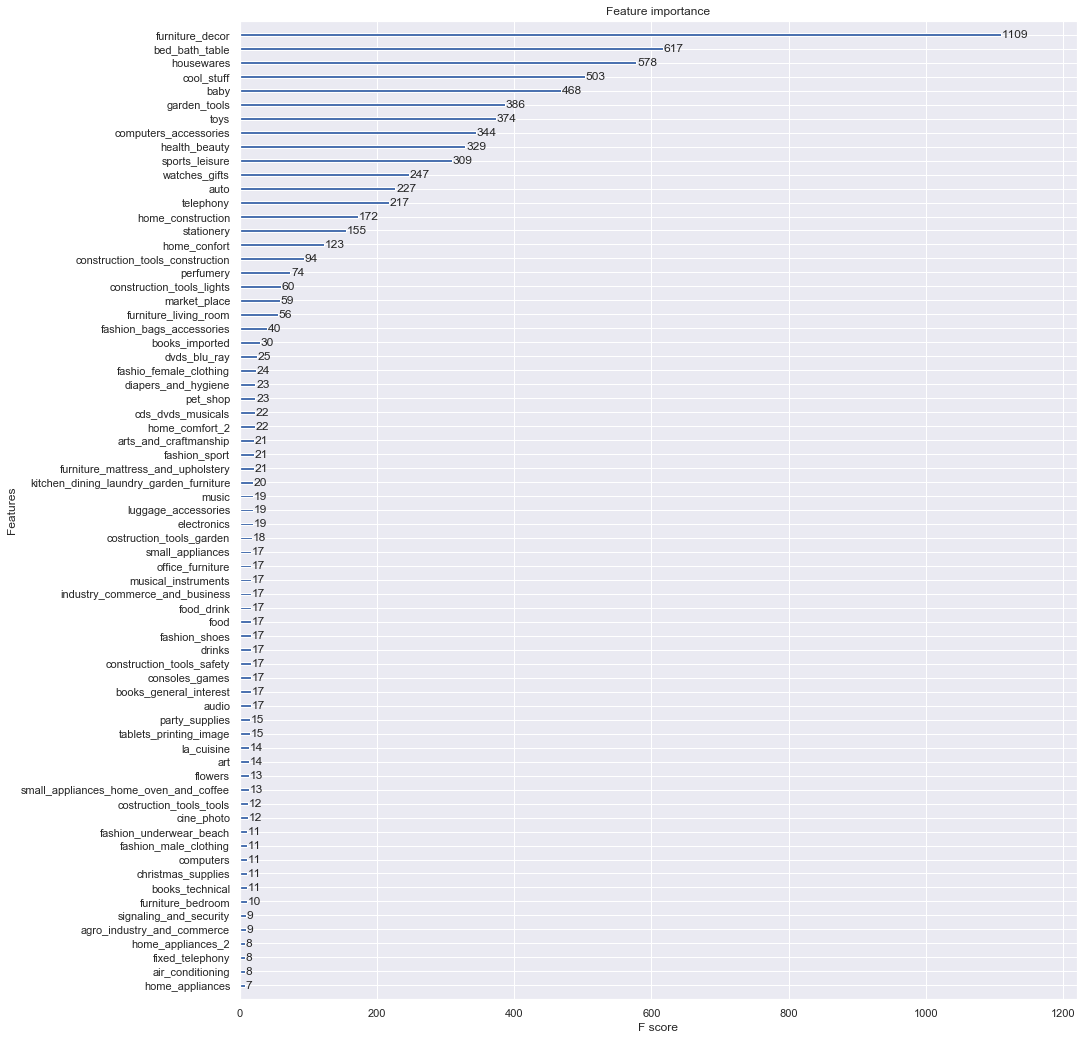

In [51]:
from xgboost import plot_importance
fig, ax = plt.subplots(figsize=(15,18))
plot_importance(xg_cl, ax = ax)
plt.show()

# The Apriori algorithm identifies frequent (high support) itemsets using something called the Apriori principle, which states that a superset that contains an infrequent item is also infrequent.

Pruning is the process of removing itemsets or association rules, typically based on the application of a metric threshold.

The mlxtend module will enable the application of the Apriori algorithm, perform pruning, and compute association rules.

apriori() is used to identify frequent itemsets and min_support set the item frequency threshold used for pruning.

In [52]:
# Apply apriori algorithm to data with min support threshold of 0.00001 and a two-item limit.
frequent_itemsets = apriori(onehot_encoded, min_support = 0.00001, max_len = 2, use_colnames = True)

# Print frequent itemsets.
frequent_itemsets

support                      itemsets
0    0.001871  (agro_industry_and_commerce)
1    0.002601            (air_conditioning)
2    0.002077                         (art)
3    0.000236       (arts_and_craftmanship)
4    0.003599                       (audio)
..        ...                           ...
308  0.000062            (toys, stationery)
309  0.000021   (stationery, watches_gifts)
310  0.000010             (toys, telephony)
311  0.000021    (watches_gifts, telephony)
312  0.000010         (toys, watches_gifts)

[313 rows x 2 columns]

By applying the apriori algorithm, itemsets are reduced to 313 without enumerating all potential 2(e71) itemsets. 

Tuning the support threshold increase the number of itemsets returned or yield itemsets with more than one item.

# Computing association rules from Apriori output 

association_rules() is used to compute and prune association rules from output of apriori(). 

Association_rules automatically computes seven metrics.

In [53]:
# Recover association rules using support and a minimum threshold of 0.00001.
rules = association_rules(frequent_itemsets, metric = 'support', min_threshold = 0.00001)

# Print rules header.
rules

antecedents              consequents  antecedent support  \
0         (air_conditioning)  (computers_accessories)            0.002601   
1    (computers_accessories)       (air_conditioning)            0.068777   
2           (sports_leisure)       (air_conditioning)            0.079378   
3         (air_conditioning)         (sports_leisure)            0.002601   
4                      (art)        (furniture_decor)            0.002077   
..                       ...                      ...                 ...   
479              (telephony)                   (toys)            0.043175   
480          (watches_gifts)              (telephony)            0.057827   
481              (telephony)          (watches_gifts)            0.043175   
482                   (toys)          (watches_gifts)            0.039956   
483          (watches_gifts)                   (toys)            0.057827   

     consequent support   support  confidence      lift  leverage  conviction  
0              0.068777  0.000010    0.003953  0.057469 -0.000169    0.934918  
1              0.002601  0.000010    0.000149  0.057469 -0.000169    0.997548  
2              0.002601  0.000010    0.000130  0.049794 -0.000196    0.997528  
3              0.079378  0.000010    0.003953  0.049794 -0.000196    0.924275  
4              0.066310  0.000051    0.024752  0.373287 -0.000086    0.957388  
..                  ...       ...         ...       ...       ...         ...  
479            0.039956  0.000010    0.000238  0.005960 -0.001715    0.960272  
480            0.043175  0.000021    0.000356  0.008237 -0.002476    0.957166  
481            0.057827  0.000021    0.000476  0.008237 -0.002476    0.942622  
482            0.057827  0.000010    0.000257  0.004450 -0.002300    0.942416  
483            0.039956  0.000010    0.000178  0.004450 -0.002300    0.960214  

[484 rows x 9 columns]

In [54]:
# Recover association rules for apriori using confidence threshold of 0.00005
rules = association_rules(frequent_itemsets, metric = 'confidence', min_threshold = 0.00005)

# Print rules.
rules

antecedents              consequents  antecedent support  \
0         (air_conditioning)  (computers_accessories)            0.002601   
1    (computers_accessories)       (air_conditioning)            0.068777   
2           (sports_leisure)       (air_conditioning)            0.079378   
3         (air_conditioning)         (sports_leisure)            0.002601   
4                      (art)        (furniture_decor)            0.002077   
..                       ...                      ...                 ...   
479              (telephony)                   (toys)            0.043175   
480          (watches_gifts)              (telephony)            0.057827   
481              (telephony)          (watches_gifts)            0.043175   
482                   (toys)          (watches_gifts)            0.039956   
483          (watches_gifts)                   (toys)            0.057827   

     consequent support   support  confidence      lift  leverage  conviction  
0              0.068777  0.000010    0.003953  0.057469 -0.000169    0.934918  
1              0.002601  0.000010    0.000149  0.057469 -0.000169    0.997548  
2              0.002601  0.000010    0.000130  0.049794 -0.000196    0.997528  
3              0.079378  0.000010    0.003953  0.049794 -0.000196    0.924275  
4              0.066310  0.000051    0.024752  0.373287 -0.000086    0.957388  
..                  ...       ...         ...       ...       ...         ...  
479            0.039956  0.000010    0.000238  0.005960 -0.001715    0.960272  
480            0.043175  0.000021    0.000356  0.008237 -0.002476    0.957166  
481            0.057827  0.000021    0.000476  0.008237 -0.002476    0.942622  
482            0.057827  0.000010    0.000257  0.004450 -0.002300    0.942416  
483            0.039956  0.000010    0.000178  0.004450 -0.002300    0.960214  

[484 rows x 9 columns]

Support metric measures the frequency with which an itemset appears in a database of transactions.

# support(X)= number of transactions containing X / total number of transactions.

A high support value indicates that items in an itemset are purchased together frequently and associated with each other.

The support metric doesnot provide information about direction.

support(antecedent,consequent) = support(consequent,antecedent)

The confidence metric has a direction. Conditional probability of the consequent, given the antecedent:

# confidence(antecedent -> consequent) = support(antecedent,consequent) / support(antecedent)

A high value of confidence indicates that the antecedent and consequent are associated and 
the direction of the association runs from the antecedent to the consequent.

The leverage metric provides a sanity check.
support(antecedent,consequent)  = joint support in data.

support(antecedent) * support(consequent)  = expected joint support for unrelated antecedent and consequent.

# Leverage formula: leverage(antecedent,consequent) = support(antecedent,consequent) − support(antecedent) * support(consequent)

Negative leverage means that the items appear together less frequently than we would expect 
if they were randomly and independently distributed across transactions. 
For most problems, itemsets with negative leverage are discarded.

# Based on business requirements, these metrics can be tuned with different thresholds to identify strong product associations.

In [55]:
# Select apriori rules with a support above 0.0002.
rules_support = rules[(rules['support'] > 0.0001) & (rules['leverage'] > 0.0)]

# Print rules.
rules_support.head()

antecedents       consequents  antecedent support  \
122  (bed_bath_table)    (home_confort)            0.096827   
123    (home_confort)  (bed_bath_table)            0.004082   

     consequent support   support  confidence      lift  leverage  conviction  
122            0.004082  0.000442    0.004566  1.118618  0.000047    1.000486  
123            0.096827  0.000442    0.108312  1.118618  0.000047    1.012881

In [56]:
# Select apriori rules with a confidence above 0.04.
rules_confidence = rules[(rules['confidence'] >= 0.04) & (rules['leverage'] > 0.00001)]

rules_confidence.head()

antecedents                 consequents  \
123               (home_confort)            (bed_bath_table)   
301  (fashion_childrens_clothes)  (fashion_bags_accessories)   

     antecedent support  consequent support   support  confidence       lift  \
123            0.004082            0.096827  0.000442    0.108312   1.118618   
301            0.000082            0.019166  0.000021    0.250000  13.043991   

     leverage  conviction  
123  0.000047    1.012881  
301  0.000019    1.307779

In [57]:
rules_confidence = rules[(rules['confidence'] >= 0.04) & (rules['support'] > 0.0001)]
rules_confidence.head()

antecedents        consequents  antecedent support  \
123               (home_confort)   (bed_bath_table)            0.004082   
229  (construction_tools_lights)  (furniture_decor)            0.002509   

     consequent support   support  confidence      lift  leverage  conviction  
123            0.096827  0.000442    0.108312  1.118618  0.000047    1.012881  
229            0.066310  0.000113    0.045082  0.679872 -0.000053    0.977770

In [58]:
# Select apriori rules with a lift above 10.00.
rules_lift = rules[(rules['lift'] > 15.00) & (rules['leverage'] > 0.0)]

# Print rules.
rules_lift

antecedents                 consequents  \
258                   (flowers)  (costruction_tools_garden)   
259  (costruction_tools_garden)                   (flowers)   
298    (fashio_female_clothing)             (fashion_sport)   
299             (fashion_sport)    (fashio_female_clothing)   

     antecedent support  consequent support  support  confidence       lift  \
258            0.000298            0.001995  0.00001    0.034483  17.286882   
259            0.001995            0.000298  0.00001    0.005155  17.286882   
298            0.000401            0.000278  0.00001    0.025641  92.360874   
299            0.000278            0.000401  0.00001    0.037037  92.360874   

     leverage  conviction  
258   0.00001    1.033648  
259   0.00001    1.004882  
298   0.00001    1.026031  
299   0.00001    1.038045

In [59]:
# Select apriori rules with a leverage above 0.00001.
rules_leverage = rules[rules['leverage'] > 0.00001]

rules_leverage

antecedents                  consequents  \
122             (bed_bath_table)               (home_confort)   
123               (home_confort)             (bed_bath_table)   
238          (home_construction)  (construction_tools_safety)   
239  (construction_tools_safety)          (home_construction)   
298     (fashio_female_clothing)              (fashion_sport)   
299              (fashion_sport)     (fashio_female_clothing)   
300   (fashion_bags_accessories)  (fashion_childrens_clothes)   
301  (fashion_childrens_clothes)   (fashion_bags_accessories)   

     antecedent support  consequent support   support  confidence       lift  \
122            0.096827            0.004082  0.000442    0.004566   1.118618   
123            0.004082            0.096827  0.000442    0.108312   1.118618   
238            0.005038            0.001717  0.000021    0.004082   2.377026   
239            0.001717            0.005038  0.000021    0.011976   2.377026   
298            0.000401            0.000278  0.000010    0.025641  92.360874   
299            0.000278            0.000401  0.000010    0.037037  92.360874   
300            0.019166            0.000082  0.000021    0.001073  13.043991   
301            0.000082            0.019166  0.000021    0.250000  13.043991   

     leverage  conviction  
122  0.000047    1.000486  
123  0.000047    1.012881  
238  0.000012    1.002374  
239  0.000012    1.007022  
298  0.000010    1.026031  
299  0.000010    1.038045  
300  0.000019    1.000992  
301  0.000019    1.307779

In [60]:
# Select apriori rules with a conviction above 1.01.
rules_conviction = rules[(rules['conviction'] > 1.02) & (rules['leverage'] > 0.00001)]

# Print rules.
rules_conviction

antecedents                 consequents  \
298     (fashio_female_clothing)             (fashion_sport)   
299              (fashion_sport)    (fashio_female_clothing)   
301  (fashion_childrens_clothes)  (fashion_bags_accessories)   

     antecedent support  consequent support   support  confidence       lift  \
298            0.000401            0.000278  0.000010    0.025641  92.360874   
299            0.000278            0.000401  0.000010    0.037037  92.360874   
301            0.000082            0.019166  0.000021    0.250000  13.043991   

     leverage  conviction  
298  0.000010    1.026031  
299  0.000010    1.038045  
301  0.000019    1.307779

# Frozensets

Note that the entries in the "itemsets" column are of type frozenset, which is built-in Python type that is similar to a Python set but immutable, which makes it more efficient for certain query or comparison operations. 
Since frozensets are sets, the item order does not matter.

To remove frozen dataset:

In [61]:
rules["antecedents"] = rules["antecedents"].apply(lambda x: list(x)[0]).astype("unicode")

In [62]:
rules["consequents"] = rules["consequents"].apply(lambda x: list(x)[0]).astype("unicode")

In [63]:
rules[rules['antecedents'] == ('home_confort')]

antecedents      consequents  antecedent support  consequent support  \
123  home_confort   bed_bath_table            0.004082            0.096827   
335  home_confort  furniture_decor            0.004082            0.066310   
411  home_confort       housewares            0.004082            0.060500   
413  home_confort    watches_gifts            0.004082            0.057827   

      support  confidence      lift  leverage  conviction  
123  0.000442    0.108312  1.118618  0.000047    1.012881  
335  0.000062    0.015113  0.227921 -0.000209    0.948018  
411  0.000010    0.002519  0.041634 -0.000237    0.941872  
413  0.000010    0.002519  0.043559 -0.000226    0.944552

In [64]:
rules.head()

antecedents            consequents  antecedent support  \
0       air_conditioning  computers_accessories            0.002601   
1  computers_accessories       air_conditioning            0.068777   
2         sports_leisure       air_conditioning            0.079378   
3       air_conditioning         sports_leisure            0.002601   
4                    art        furniture_decor            0.002077   

   consequent support   support  confidence      lift  leverage  conviction  
0            0.068777  0.000010    0.003953  0.057469 -0.000169    0.934918  
1            0.002601  0.000010    0.000149  0.057469 -0.000169    0.997548  
2            0.002601  0.000010    0.000130  0.049794 -0.000196    0.997528  
3            0.079378  0.000010    0.003953  0.049794 -0.000196    0.924275  
4            0.066310  0.000051    0.024752  0.373287 -0.000086    0.957388

In [65]:
rules.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 484 entries, 0 to 483
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   antecedents         484 non-null    object 
 1   consequents         484 non-null    object 
 2   antecedent support  484 non-null    float64
 3   consequent support  484 non-null    float64
 4   support             484 non-null    float64
 5   confidence          484 non-null    float64
 6   lift                484 non-null    float64
 7   leverage            484 non-null    float64
 8   conviction          484 non-null    float64
dtypes: float64(7), object(2)
memory usage: 34.2+ KB


In [66]:
transactions_merged.head()

product_category_name_english  agro_industry_and_commerce  air_conditioning  \
0                    cool_stuff                       False             False   
1                      pet_shop                       False             False   
2               furniture_decor                       False             False   
3                     perfumery                       False             False   
4                  garden_tools                       False             False   

     art  arts_and_craftmanship  audio   auto   baby  bed_bath_table  \
0  False                  False  False  False  False           False   
1  False                  False  False  False  False           False   
2  False                  False  False  False  False           False   
3  False                  False  False  False  False           False   
4  False                  False  False  False  False           False   

   books_general_interest  ...  security_and_services  signaling_and_security  \
0                   False  ...                  False                   False   
1                   False  ...                  False                   False   
2                   False  ...                  False                   False   
3                   False  ...                  False                   False   
4                   False  ...                  False                   False   

   small_appliances  small_appliances_home_oven_and_coffee  sports_leisure  \
0             False                                  False           False   
1             False                                  False           False   
2             False                                  False           False   
3             False                                  False           False   
4             False                                  False           False   

   stationery  tablets_printing_image  telephony   toys  watches_gifts  
0       False                   False      False  False          False  
1       False                   False      False  False          False  
2       False                   False      False  False          False  
3       False                   False      False  False          False  
4       False                   False      False  False          False  

[5 rows x 72 columns]

The align the rows in the rules and transactions DataFrames, I defined empty columns for antecedents and consequents in the transactions DataFrame and used loop over the rows of "rules" for each row of "transactions" 
and then retain the antecedent / consequent if there is a match. 

In [67]:
transactions_merged['antecedents']= ''

In [68]:
transactions_merged['consequents']= ''

In [69]:
transactions_merged.head()

product_category_name_english  agro_industry_and_commerce  air_conditioning  \
0                    cool_stuff                       False             False   
1                      pet_shop                       False             False   
2               furniture_decor                       False             False   
3                     perfumery                       False             False   
4                  garden_tools                       False             False   

     art  arts_and_craftmanship  audio   auto   baby  bed_bath_table  \
0  False                  False  False  False  False           False   
1  False                  False  False  False  False           False   
2  False                  False  False  False  False           False   
3  False                  False  False  False  False           False   
4  False                  False  False  False  False           False   

   books_general_interest  ...  small_appliances  \
0                   False  ...             False   
1                   False  ...             False   
2                   False  ...             False   
3                   False  ...             False   
4                   False  ...             False   

   small_appliances_home_oven_and_coffee  sports_leisure  stationery  \
0                                  False           False       False   
1                                  False           False       False   
2                                  False           False       False   
3                                  False           False       False   
4                                  False           False       False   

   tablets_printing_image  telephony   toys  watches_gifts  antecedents  \
0                   False      False  False          False                
1                   False      False  False          False                
2                   False      False  False          False                
3                   False      False  False          False                
4                   False      False  False          False                

   consequents  
0               
1               
2               
3               
4               

[5 rows x 74 columns]

In [70]:
common = rules.merge(transactions_merged,on=['antecedents','consequents'])
print(common)

Empty DataFrame
Columns: [antecedents, consequents, antecedent support, consequent support, support, confidence, lift, leverage, conviction, product_category_name_english, agro_industry_and_commerce, air_conditioning, art, arts_and_craftmanship, audio, auto, baby, bed_bath_table, books_general_interest, books_imported, books_technical, cds_dvds_musicals, christmas_supplies, cine_photo, computers, computers_accessories, consoles_games, construction_tools_construction, construction_tools_lights, construction_tools_safety, cool_stuff, costruction_tools_garden, costruction_tools_tools, diapers_and_hygiene, drinks, dvds_blu_ray, electronics, fashio_female_clothing, fashion_bags_accessories, fashion_childrens_clothes, fashion_male_clothing, fashion_shoes, fashion_sport, fashion_underwear_beach, fixed_telephony, flowers, food, food_drink, furniture_bedroom, furniture_decor, furniture_living_room, furniture_mattress_and_upholstery, garden_tools, health_beauty, home_appliances, home_appliances_

In [71]:
rules_df = rules[(~rules.antecedents.isin(common.antecedents))&(~rules.consequents.isin(common.consequents))]
rules_df

antecedents            consequents  antecedent support  \
0         air_conditioning  computers_accessories            0.002601   
1    computers_accessories       air_conditioning            0.068777   
2           sports_leisure       air_conditioning            0.079378   
3         air_conditioning         sports_leisure            0.002601   
4                      art        furniture_decor            0.002077   
..                     ...                    ...                 ...   
479              telephony                   toys            0.043175   
480          watches_gifts              telephony            0.057827   
481              telephony          watches_gifts            0.043175   
482                   toys          watches_gifts            0.039956   
483          watches_gifts                   toys            0.057827   

     consequent support   support  confidence      lift  leverage  conviction  
0              0.068777  0.000010    0.003953  0.057469 -0.000169    0.934918  
1              0.002601  0.000010    0.000149  0.057469 -0.000169    0.997548  
2              0.002601  0.000010    0.000130  0.049794 -0.000196    0.997528  
3              0.079378  0.000010    0.003953  0.049794 -0.000196    0.924275  
4              0.066310  0.000051    0.024752  0.373287 -0.000086    0.957388  
..                  ...       ...         ...       ...       ...         ...  
479            0.039956  0.000010    0.000238  0.005960 -0.001715    0.960272  
480            0.043175  0.000021    0.000356  0.008237 -0.002476    0.957166  
481            0.057827  0.000021    0.000476  0.008237 -0.002476    0.942622  
482            0.057827  0.000010    0.000257  0.004450 -0.002300    0.942416  
483            0.039956  0.000010    0.000178  0.004450 -0.002300    0.960214  

[484 rows x 9 columns]

In [72]:
rules_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 484 entries, 0 to 483
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   antecedents         484 non-null    object 
 1   consequents         484 non-null    object 
 2   antecedent support  484 non-null    float64
 3   consequent support  484 non-null    float64
 4   support             484 non-null    float64
 5   confidence          484 non-null    float64
 6   lift                484 non-null    float64
 7   leverage            484 non-null    float64
 8   conviction          484 non-null    float64
dtypes: float64(7), object(2)
memory usage: 37.8+ KB


In [73]:
X = rules_df.iloc[:,rules_df.columns!='consequents']
y = rules_df['consequents']

In [74]:
type(X)

pandas.core.frame.DataFrame

In [75]:
type(y)

pandas.core.series.Series

In [76]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state=123)

In [77]:
X_train.shape, y_train.shape

((314, 8), (314,))

In [78]:
X_test.shape, y_test.shape

((170, 8), (170,))

# Catboost (Categorical features support) improve training results. CatBoost allows to use non-numeric factors, instead of having to pre-process data or spend time and effort turning it to numbers.

In [79]:
cl_cb = CatBoostClassifier()

In [80]:
cat_features_index = np.where(X.dtypes != np.float)[0]

In [81]:
cl_cb.fit(X_train, y_train, plot=True, cat_features=cat_features_index)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.074588
0:	learn: 3.9966490	total: 404ms	remaining: 6m 43s
1:	learn: 3.9597803	total: 766ms	remaining: 6m 22s
2:	learn: 3.9303019	total: 1.07s	remaining: 5m 56s
3:	learn: 3.9009173	total: 1.42s	remaining: 5m 53s
4:	learn: 3.8760940	total: 1.61s	remaining: 5m 21s
5:	learn: 3.8466591	total: 1.93s	remaining: 5m 19s
6:	learn: 3.8217934	total: 2.15s	remaining: 5m 5s
7:	learn: 3.7776763	total: 2.43s	remaining: 5m 1s
8:	learn: 3.7137169	total: 2.46s	remaining: 4m 31s
9:	learn: 3.6660245	total: 2.52s	remaining: 4m 9s
10:	learn: 3.6266021	total: 2.85s	remaining: 4m 16s
11:	learn: 3.5762963	total: 2.95s	remaining: 4m 2s
12:	learn: 3.5354582	total: 3.25s	remaining: 4m 6s
13:	learn: 3.5159908	total: 3.49s	remaining: 4m 5s
14:	learn: 3.4938723	total: 3.82s	remaining: 4m 10s
15:	learn: 3.4298545	total: 4.14s	remaining: 4m 14s
16:	learn: 3.3991341	total: 4.45s	remaining: 4m 17s
17:	learn: 3.3761195	total: 4.78s	remaining: 4m 21s
18:	learn: 3.3566472	total: 5.06s	remaining: 4m 21

159:	learn: 1.1357928	total: 47.6s	remaining: 4m 9s
160:	learn: 1.1303585	total: 47.9s	remaining: 4m 9s
161:	learn: 1.1236594	total: 48.2s	remaining: 4m 9s
162:	learn: 1.1178405	total: 48.5s	remaining: 4m 9s
163:	learn: 1.1122980	total: 48.9s	remaining: 4m 9s
164:	learn: 1.1093822	total: 49.2s	remaining: 4m 9s
165:	learn: 1.0999460	total: 49.5s	remaining: 4m 8s
166:	learn: 1.0885841	total: 49.9s	remaining: 4m 8s
167:	learn: 1.0820010	total: 50.2s	remaining: 4m 8s
168:	learn: 1.0681962	total: 50.5s	remaining: 4m 8s
169:	learn: 1.0621919	total: 50.9s	remaining: 4m 8s
170:	learn: 1.0568644	total: 51.2s	remaining: 4m 8s
171:	learn: 1.0520324	total: 51.5s	remaining: 4m 8s
172:	learn: 1.0464552	total: 51.8s	remaining: 4m 7s
173:	learn: 1.0404584	total: 52.2s	remaining: 4m 7s
174:	learn: 1.0357747	total: 52.5s	remaining: 4m 7s
175:	learn: 1.0258589	total: 52.8s	remaining: 4m 7s
176:	learn: 1.0183665	total: 53.1s	remaining: 4m 7s
177:	learn: 1.0123801	total: 53.5s	remaining: 4m 6s
178:	learn: 

314:	learn: 0.5124886	total: 1m 38s	remaining: 3m 34s
315:	learn: 0.5105803	total: 1m 38s	remaining: 3m 34s
316:	learn: 0.5090283	total: 1m 39s	remaining: 3m 33s
317:	learn: 0.5074973	total: 1m 39s	remaining: 3m 33s
318:	learn: 0.5029960	total: 1m 39s	remaining: 3m 33s
319:	learn: 0.5011914	total: 1m 40s	remaining: 3m 33s
320:	learn: 0.4992313	total: 1m 40s	remaining: 3m 32s
321:	learn: 0.4966922	total: 1m 41s	remaining: 3m 32s
322:	learn: 0.4950820	total: 1m 41s	remaining: 3m 32s
323:	learn: 0.4943926	total: 1m 41s	remaining: 3m 32s
324:	learn: 0.4925077	total: 1m 41s	remaining: 3m 31s
325:	learn: 0.4906530	total: 1m 42s	remaining: 3m 31s
326:	learn: 0.4893529	total: 1m 42s	remaining: 3m 31s
327:	learn: 0.4867508	total: 1m 42s	remaining: 3m 30s
328:	learn: 0.4849963	total: 1m 43s	remaining: 3m 30s
329:	learn: 0.4833010	total: 1m 43s	remaining: 3m 30s
330:	learn: 0.4772573	total: 1m 43s	remaining: 3m 30s
331:	learn: 0.4751479	total: 1m 44s	remaining: 3m 29s
332:	learn: 0.4737825	total:

468:	learn: 0.2889742	total: 2m 29s	remaining: 2m 49s
469:	learn: 0.2868095	total: 2m 30s	remaining: 2m 49s
470:	learn: 0.2862777	total: 2m 30s	remaining: 2m 49s
471:	learn: 0.2855167	total: 2m 30s	remaining: 2m 48s
472:	learn: 0.2845806	total: 2m 31s	remaining: 2m 48s
473:	learn: 0.2840014	total: 2m 31s	remaining: 2m 48s
474:	learn: 0.2819817	total: 2m 31s	remaining: 2m 47s
475:	learn: 0.2812725	total: 2m 32s	remaining: 2m 47s
476:	learn: 0.2810675	total: 2m 32s	remaining: 2m 47s
477:	learn: 0.2802913	total: 2m 32s	remaining: 2m 46s
478:	learn: 0.2796505	total: 2m 33s	remaining: 2m 46s
479:	learn: 0.2785544	total: 2m 33s	remaining: 2m 46s
480:	learn: 0.2778292	total: 2m 33s	remaining: 2m 45s
481:	learn: 0.2765887	total: 2m 34s	remaining: 2m 45s
482:	learn: 0.2759256	total: 2m 34s	remaining: 2m 45s
483:	learn: 0.2756072	total: 2m 34s	remaining: 2m 44s
484:	learn: 0.2751763	total: 2m 35s	remaining: 2m 44s
485:	learn: 0.2729141	total: 2m 35s	remaining: 2m 44s
486:	learn: 0.2723471	total:

621:	learn: 0.1893717	total: 3m 20s	remaining: 2m 1s
622:	learn: 0.1890730	total: 3m 20s	remaining: 2m 1s
623:	learn: 0.1887404	total: 3m 20s	remaining: 2m 1s
624:	learn: 0.1884737	total: 3m 21s	remaining: 2m
625:	learn: 0.1879856	total: 3m 21s	remaining: 2m
626:	learn: 0.1878152	total: 3m 21s	remaining: 2m
627:	learn: 0.1874196	total: 3m 22s	remaining: 1m 59s
628:	learn: 0.1871611	total: 3m 22s	remaining: 1m 59s
629:	learn: 0.1867748	total: 3m 22s	remaining: 1m 59s
630:	learn: 0.1862547	total: 3m 23s	remaining: 1m 58s
631:	learn: 0.1858083	total: 3m 23s	remaining: 1m 58s
632:	learn: 0.1855374	total: 3m 23s	remaining: 1m 58s
633:	learn: 0.1849639	total: 3m 24s	remaining: 1m 57s
634:	learn: 0.1845195	total: 3m 24s	remaining: 1m 57s
635:	learn: 0.1840114	total: 3m 24s	remaining: 1m 57s
636:	learn: 0.1831128	total: 3m 25s	remaining: 1m 56s
637:	learn: 0.1828076	total: 3m 25s	remaining: 1m 56s
638:	learn: 0.1823826	total: 3m 25s	remaining: 1m 56s
639:	learn: 0.1821444	total: 3m 26s	remaini

774:	learn: 0.1375032	total: 4m 10s	remaining: 1m 12s
775:	learn: 0.1368608	total: 4m 10s	remaining: 1m 12s
776:	learn: 0.1367640	total: 4m 11s	remaining: 1m 12s
777:	learn: 0.1365677	total: 4m 11s	remaining: 1m 11s
778:	learn: 0.1363616	total: 4m 12s	remaining: 1m 11s
779:	learn: 0.1362753	total: 4m 12s	remaining: 1m 11s
780:	learn: 0.1361229	total: 4m 12s	remaining: 1m 10s
781:	learn: 0.1359676	total: 4m 13s	remaining: 1m 10s
782:	learn: 0.1357432	total: 4m 13s	remaining: 1m 10s
783:	learn: 0.1353729	total: 4m 13s	remaining: 1m 9s
784:	learn: 0.1353295	total: 4m 14s	remaining: 1m 9s
785:	learn: 0.1351289	total: 4m 14s	remaining: 1m 9s
786:	learn: 0.1348513	total: 4m 14s	remaining: 1m 8s
787:	learn: 0.1343800	total: 4m 14s	remaining: 1m 8s
788:	learn: 0.1341719	total: 4m 15s	remaining: 1m 8s
789:	learn: 0.1340582	total: 4m 15s	remaining: 1m 7s
790:	learn: 0.1339166	total: 4m 15s	remaining: 1m 7s
791:	learn: 0.1335246	total: 4m 16s	remaining: 1m 7s
792:	learn: 0.1333707	total: 4m 16s	r

930:	learn: 0.1074849	total: 5m 2s	remaining: 22.4s
931:	learn: 0.1074132	total: 5m 2s	remaining: 22.1s
932:	learn: 0.1072264	total: 5m 2s	remaining: 21.7s
933:	learn: 0.1071945	total: 5m 3s	remaining: 21.4s
934:	learn: 0.1071172	total: 5m 3s	remaining: 21.1s
935:	learn: 0.1065820	total: 5m 3s	remaining: 20.8s
936:	learn: 0.1064908	total: 5m 4s	remaining: 20.5s
937:	learn: 0.1064199	total: 5m 4s	remaining: 20.1s
938:	learn: 0.1063719	total: 5m 4s	remaining: 19.8s
939:	learn: 0.1062141	total: 5m 5s	remaining: 19.5s
940:	learn: 0.1059930	total: 5m 5s	remaining: 19.2s
941:	learn: 0.1058192	total: 5m 5s	remaining: 18.8s
942:	learn: 0.1056574	total: 5m 6s	remaining: 18.5s
943:	learn: 0.1056262	total: 5m 6s	remaining: 18.2s
944:	learn: 0.1055279	total: 5m 6s	remaining: 17.9s
945:	learn: 0.1053981	total: 5m 7s	remaining: 17.5s
946:	learn: 0.1053018	total: 5m 7s	remaining: 17.2s
947:	learn: 0.1052125	total: 5m 7s	remaining: 16.9s
948:	learn: 0.1050332	total: 5m 8s	remaining: 16.6s
949:	learn: 

In [82]:
y_pred_cb = cl_cb.predict(X_test)

In [83]:
print("accuracy of the catboost: ",accuracy_score(y_test,y_pred_cb))

accuracy of the catboost:  0.7294117647058823


In [84]:
clf_cat = CatBoostClassifier(
    depth = 7, 
    iterations = 1000, 
    learning_rate =  0.3
)

In [85]:
clf_cat.fit(X_train, y_train, cat_features=cat_features_index)

0:	learn: 3.8884492	total: 732ms	remaining: 12m 11s
1:	learn: 3.7514756	total: 1.51s	remaining: 12m 35s
2:	learn: 3.6492232	total: 1.98s	remaining: 10m 57s
3:	learn: 3.5412566	total: 2.77s	remaining: 11m 30s
4:	learn: 3.3999858	total: 2.88s	remaining: 9m 32s
5:	learn: 3.3092372	total: 3.58s	remaining: 9m 53s
6:	learn: 3.1731178	total: 4.37s	remaining: 10m 19s
7:	learn: 3.0714558	total: 5.15s	remaining: 10m 38s
8:	learn: 2.9717798	total: 5.98s	remaining: 10m 58s
9:	learn: 2.9040143	total: 6.51s	remaining: 10m 44s
10:	learn: 2.8019961	total: 7.29s	remaining: 10m 55s
11:	learn: 2.7540207	total: 7.75s	remaining: 10m 38s
12:	learn: 2.6763617	total: 8.53s	remaining: 10m 47s
13:	learn: 2.6160242	total: 9.33s	remaining: 10m 57s
14:	learn: 2.5523573	total: 10.1s	remaining: 11m 3s
15:	learn: 2.5272935	total: 10.1s	remaining: 10m 22s
16:	learn: 2.4683336	total: 10.9s	remaining: 10m 29s
17:	learn: 2.3724948	total: 11.7s	remaining: 10m 36s
18:	learn: 2.3089178	total: 12.4s	remaining: 10m 42s
19:	le

154:	learn: 0.1522476	total: 1m 57s	remaining: 10m 41s
155:	learn: 0.1510407	total: 1m 58s	remaining: 10m 41s
156:	learn: 0.1478754	total: 1m 59s	remaining: 10m 41s
157:	learn: 0.1470522	total: 2m	remaining: 10m 39s
158:	learn: 0.1456032	total: 2m	remaining: 10m 39s
159:	learn: 0.1446134	total: 2m 1s	remaining: 10m 38s
160:	learn: 0.1434782	total: 2m 2s	remaining: 10m 37s
161:	learn: 0.1424178	total: 2m 3s	remaining: 10m 37s
162:	learn: 0.1418948	total: 2m 3s	remaining: 10m 36s
163:	learn: 0.1410115	total: 2m 4s	remaining: 10m 35s
164:	learn: 0.1399955	total: 2m 5s	remaining: 10m 34s
165:	learn: 0.1378458	total: 2m 6s	remaining: 10m 33s
166:	learn: 0.1367234	total: 2m 6s	remaining: 10m 32s
167:	learn: 0.1352829	total: 2m 7s	remaining: 10m 32s
168:	learn: 0.1343895	total: 2m 8s	remaining: 10m 31s
169:	learn: 0.1335194	total: 2m 9s	remaining: 10m 30s
170:	learn: 0.1327135	total: 2m 9s	remaining: 10m 29s
171:	learn: 0.1317167	total: 2m 10s	remaining: 10m 28s
172:	learn: 0.1310263	total: 2

306:	learn: 0.0600382	total: 3m 54s	remaining: 8m 48s
307:	learn: 0.0598429	total: 3m 54s	remaining: 8m 47s
308:	learn: 0.0591920	total: 3m 55s	remaining: 8m 46s
309:	learn: 0.0589884	total: 3m 56s	remaining: 8m 46s
310:	learn: 0.0585483	total: 3m 57s	remaining: 8m 45s
311:	learn: 0.0583623	total: 3m 57s	remaining: 8m 44s
312:	learn: 0.0582503	total: 3m 58s	remaining: 8m 43s
313:	learn: 0.0579604	total: 3m 59s	remaining: 8m 42s
314:	learn: 0.0577858	total: 4m	remaining: 8m 42s
315:	learn: 0.0576152	total: 4m	remaining: 8m 41s
316:	learn: 0.0573809	total: 4m 1s	remaining: 8m 40s
317:	learn: 0.0572390	total: 4m 2s	remaining: 8m 39s
318:	learn: 0.0571060	total: 4m 3s	remaining: 8m 39s
319:	learn: 0.0569378	total: 4m 3s	remaining: 8m 38s
320:	learn: 0.0567638	total: 4m 4s	remaining: 8m 37s
321:	learn: 0.0565768	total: 4m 5s	remaining: 8m 36s
322:	learn: 0.0565144	total: 4m 6s	remaining: 8m 36s
323:	learn: 0.0562998	total: 4m 7s	remaining: 8m 35s
324:	learn: 0.0555276	total: 4m 7s	remaining

459:	learn: 0.0366667	total: 5m 53s	remaining: 6m 54s
460:	learn: 0.0365954	total: 5m 53s	remaining: 6m 53s
461:	learn: 0.0365338	total: 5m 54s	remaining: 6m 52s
462:	learn: 0.0364554	total: 5m 55s	remaining: 6m 52s
463:	learn: 0.0363707	total: 5m 56s	remaining: 6m 51s
464:	learn: 0.0363069	total: 5m 56s	remaining: 6m 50s
465:	learn: 0.0362643	total: 5m 57s	remaining: 6m 50s
466:	learn: 0.0361913	total: 5m 58s	remaining: 6m 49s
467:	learn: 0.0361128	total: 5m 59s	remaining: 6m 48s
468:	learn: 0.0360212	total: 6m	remaining: 6m 47s
469:	learn: 0.0359391	total: 6m	remaining: 6m 46s
470:	learn: 0.0358573	total: 6m 1s	remaining: 6m 46s
471:	learn: 0.0357526	total: 6m 2s	remaining: 6m 45s
472:	learn: 0.0356757	total: 6m 3s	remaining: 6m 44s
473:	learn: 0.0356077	total: 6m 3s	remaining: 6m 43s
474:	learn: 0.0355369	total: 6m 4s	remaining: 6m 43s
475:	learn: 0.0354750	total: 6m 5s	remaining: 6m 42s
476:	learn: 0.0354325	total: 6m 6s	remaining: 6m 41s
477:	learn: 0.0353781	total: 6m 6s	remainin

613:	learn: 0.0269588	total: 7m 49s	remaining: 4m 55s
614:	learn: 0.0269289	total: 7m 50s	remaining: 4m 54s
615:	learn: 0.0268884	total: 7m 51s	remaining: 4m 53s
616:	learn: 0.0268209	total: 7m 52s	remaining: 4m 53s
617:	learn: 0.0267619	total: 7m 52s	remaining: 4m 52s
618:	learn: 0.0267194	total: 7m 53s	remaining: 4m 51s
619:	learn: 0.0266834	total: 7m 54s	remaining: 4m 50s
620:	learn: 0.0266476	total: 7m 55s	remaining: 4m 50s
621:	learn: 0.0265892	total: 7m 56s	remaining: 4m 49s
622:	learn: 0.0264559	total: 7m 56s	remaining: 4m 48s
623:	learn: 0.0263614	total: 7m 57s	remaining: 4m 47s
624:	learn: 0.0262989	total: 7m 58s	remaining: 4m 47s
625:	learn: 0.0262626	total: 7m 59s	remaining: 4m 46s
626:	learn: 0.0262142	total: 7m 59s	remaining: 4m 45s
627:	learn: 0.0261690	total: 8m	remaining: 4m 44s
628:	learn: 0.0261264	total: 8m 1s	remaining: 4m 43s
629:	learn: 0.0260815	total: 8m 2s	remaining: 4m 43s
630:	learn: 0.0260477	total: 8m 2s	remaining: 4m 42s
631:	learn: 0.0260034	total: 8m 3s	

767:	learn: 0.0207354	total: 9m 47s	remaining: 2m 57s
768:	learn: 0.0207104	total: 9m 48s	remaining: 2m 56s
769:	learn: 0.0206840	total: 9m 49s	remaining: 2m 55s
770:	learn: 0.0206565	total: 9m 49s	remaining: 2m 55s
771:	learn: 0.0206316	total: 9m 50s	remaining: 2m 54s
772:	learn: 0.0206160	total: 9m 51s	remaining: 2m 53s
773:	learn: 0.0205855	total: 9m 52s	remaining: 2m 52s
774:	learn: 0.0205462	total: 9m 52s	remaining: 2m 52s
775:	learn: 0.0205093	total: 9m 53s	remaining: 2m 51s
776:	learn: 0.0204891	total: 9m 54s	remaining: 2m 50s
777:	learn: 0.0204673	total: 9m 55s	remaining: 2m 49s
778:	learn: 0.0204437	total: 9m 56s	remaining: 2m 49s
779:	learn: 0.0204079	total: 9m 56s	remaining: 2m 48s
780:	learn: 0.0203802	total: 9m 57s	remaining: 2m 47s
781:	learn: 0.0203529	total: 9m 58s	remaining: 2m 46s
782:	learn: 0.0203296	total: 9m 59s	remaining: 2m 46s
783:	learn: 0.0202974	total: 10m	remaining: 2m 45s
784:	learn: 0.0202451	total: 10m	remaining: 2m 44s
785:	learn: 0.0202280	total: 10m 1

918:	learn: 0.0171432	total: 11m 43s	remaining: 1m 1s
919:	learn: 0.0171313	total: 11m 43s	remaining: 1m 1s
920:	learn: 0.0171119	total: 11m 44s	remaining: 1m
921:	learn: 0.0170974	total: 11m 45s	remaining: 59.7s
922:	learn: 0.0170630	total: 11m 46s	remaining: 58.9s
923:	learn: 0.0170426	total: 11m 46s	remaining: 58.1s
924:	learn: 0.0170247	total: 11m 47s	remaining: 57.4s
925:	learn: 0.0169643	total: 11m 48s	remaining: 56.6s
926:	learn: 0.0169495	total: 11m 49s	remaining: 55.9s
927:	learn: 0.0169328	total: 11m 50s	remaining: 55.1s
928:	learn: 0.0169106	total: 11m 50s	remaining: 54.3s
929:	learn: 0.0168884	total: 11m 51s	remaining: 53.6s
930:	learn: 0.0168653	total: 11m 52s	remaining: 52.8s
931:	learn: 0.0168504	total: 11m 53s	remaining: 52s
932:	learn: 0.0168408	total: 11m 53s	remaining: 51.3s
933:	learn: 0.0168039	total: 11m 54s	remaining: 50.5s
934:	learn: 0.0167863	total: 11m 55s	remaining: 49.7s
935:	learn: 0.0167522	total: 11m 56s	remaining: 49s
936:	learn: 0.0167225	total: 11m 56

In [86]:
y_pred_cat = clf_cat.predict(X_test)

In [87]:
print("accuracy of the catboost: ",accuracy_score(y_test,y_pred_cat))

accuracy of the catboost:  0.7


In [88]:
pool = Pool(X, y, cat_features=cat_features_index, feature_names=list(X.columns))

In [89]:
cl_cat = CatBoostClassifier(
    depth = 7, 
    iterations = 1000, 
    learning_rate =  0.3
).fit(pool)

0:	learn: 3.9397963	total: 901ms	remaining: 15m
1:	learn: 3.7959929	total: 1.72s	remaining: 14m 16s
2:	learn: 3.4585462	total: 2.62s	remaining: 14m 31s
3:	learn: 3.3374729	total: 3.51s	remaining: 14m 33s
4:	learn: 3.2432568	total: 4.33s	remaining: 14m 21s
5:	learn: 3.1559760	total: 5.19s	remaining: 14m 19s
6:	learn: 3.0901096	total: 5.21s	remaining: 12m 18s
7:	learn: 2.8919863	total: 6.19s	remaining: 12m 47s
8:	learn: 2.8011897	total: 7.21s	remaining: 13m 14s
9:	learn: 2.7396119	total: 8.12s	remaining: 13m 23s
10:	learn: 2.6811516	total: 9s	remaining: 13m 29s
11:	learn: 2.6515014	total: 9.55s	remaining: 13m 6s
12:	learn: 2.5825978	total: 10.4s	remaining: 13m 10s
13:	learn: 2.5231697	total: 11.3s	remaining: 13m 14s
14:	learn: 2.4840840	total: 11.3s	remaining: 12m 23s
15:	learn: 2.4117072	total: 12.2s	remaining: 12m 32s
16:	learn: 2.3560762	total: 13.1s	remaining: 12m 38s
17:	learn: 2.2771399	total: 14s	remaining: 12m 42s
18:	learn: 2.1912291	total: 14.8s	remaining: 12m 45s
19:	learn: 2.

154:	learn: 0.1351013	total: 2m 17s	remaining: 12m 32s
155:	learn: 0.1327385	total: 2m 18s	remaining: 12m 31s
156:	learn: 0.1318356	total: 2m 19s	remaining: 12m 30s
157:	learn: 0.1307489	total: 2m 20s	remaining: 12m 29s
158:	learn: 0.1298705	total: 2m 21s	remaining: 12m 28s
159:	learn: 0.1287000	total: 2m 22s	remaining: 12m 27s
160:	learn: 0.1276774	total: 2m 23s	remaining: 12m 27s
161:	learn: 0.1269098	total: 2m 24s	remaining: 12m 26s
162:	learn: 0.1240176	total: 2m 25s	remaining: 12m 25s
163:	learn: 0.1230520	total: 2m 26s	remaining: 12m 24s
164:	learn: 0.1216728	total: 2m 26s	remaining: 12m 23s
165:	learn: 0.1212188	total: 2m 27s	remaining: 12m 22s
166:	learn: 0.1205730	total: 2m 28s	remaining: 12m 21s
167:	learn: 0.1195218	total: 2m 29s	remaining: 12m 21s
168:	learn: 0.1182747	total: 2m 30s	remaining: 12m 20s
169:	learn: 0.1175785	total: 2m 31s	remaining: 12m 20s
170:	learn: 0.1167849	total: 2m 32s	remaining: 12m 19s
171:	learn: 0.1159944	total: 2m 33s	remaining: 12m 18s
172:	learn

305:	learn: 0.0527568	total: 4m 33s	remaining: 10m 21s
306:	learn: 0.0526333	total: 4m 34s	remaining: 10m 20s
307:	learn: 0.0525200	total: 4m 35s	remaining: 10m 19s
308:	learn: 0.0523968	total: 4m 36s	remaining: 10m 18s
309:	learn: 0.0522582	total: 4m 37s	remaining: 10m 17s
310:	learn: 0.0521035	total: 4m 38s	remaining: 10m 17s
311:	learn: 0.0519258	total: 4m 39s	remaining: 10m 16s
312:	learn: 0.0517292	total: 4m 40s	remaining: 10m 15s
313:	learn: 0.0516043	total: 4m 41s	remaining: 10m 14s
314:	learn: 0.0513425	total: 4m 42s	remaining: 10m 13s
315:	learn: 0.0511994	total: 4m 43s	remaining: 10m 12s
316:	learn: 0.0510151	total: 4m 43s	remaining: 10m 11s
317:	learn: 0.0504787	total: 4m 44s	remaining: 10m 10s
318:	learn: 0.0502564	total: 4m 45s	remaining: 10m 9s
319:	learn: 0.0501102	total: 4m 46s	remaining: 10m 9s
320:	learn: 0.0499337	total: 4m 47s	remaining: 10m 8s
321:	learn: 0.0498256	total: 4m 48s	remaining: 10m 7s
322:	learn: 0.0497280	total: 4m 49s	remaining: 10m 6s
323:	learn: 0.0

458:	learn: 0.0331273	total: 6m 51s	remaining: 8m 4s
459:	learn: 0.0330818	total: 6m 51s	remaining: 8m 3s
460:	learn: 0.0330035	total: 6m 52s	remaining: 8m 2s
461:	learn: 0.0329262	total: 6m 53s	remaining: 8m 1s
462:	learn: 0.0328655	total: 6m 54s	remaining: 8m
463:	learn: 0.0327706	total: 6m 55s	remaining: 8m
464:	learn: 0.0326286	total: 6m 56s	remaining: 7m 59s
465:	learn: 0.0325742	total: 6m 57s	remaining: 7m 58s
466:	learn: 0.0322793	total: 6m 58s	remaining: 7m 57s
467:	learn: 0.0321688	total: 6m 59s	remaining: 7m 56s
468:	learn: 0.0319924	total: 6m 59s	remaining: 7m 55s
469:	learn: 0.0319027	total: 7m	remaining: 7m 54s
470:	learn: 0.0318235	total: 7m 1s	remaining: 7m 53s
471:	learn: 0.0317647	total: 7m 2s	remaining: 7m 53s
472:	learn: 0.0317039	total: 7m 3s	remaining: 7m 52s
473:	learn: 0.0316668	total: 7m 4s	remaining: 7m 51s
474:	learn: 0.0316045	total: 7m 5s	remaining: 7m 50s
475:	learn: 0.0315310	total: 7m 6s	remaining: 7m 49s
476:	learn: 0.0314758	total: 7m 7s	remaining: 7m 4

612:	learn: 0.0236960	total: 9m 10s	remaining: 5m 47s
613:	learn: 0.0236659	total: 9m 11s	remaining: 5m 46s
614:	learn: 0.0236132	total: 9m 12s	remaining: 5m 45s
615:	learn: 0.0235063	total: 9m 12s	remaining: 5m 44s
616:	learn: 0.0234738	total: 9m 13s	remaining: 5m 43s
617:	learn: 0.0234362	total: 9m 14s	remaining: 5m 42s
618:	learn: 0.0234027	total: 9m 15s	remaining: 5m 42s
619:	learn: 0.0233820	total: 9m 16s	remaining: 5m 41s
620:	learn: 0.0231996	total: 9m 17s	remaining: 5m 40s
621:	learn: 0.0231920	total: 9m 18s	remaining: 5m 39s
622:	learn: 0.0231607	total: 9m 19s	remaining: 5m 38s
623:	learn: 0.0231294	total: 9m 20s	remaining: 5m 37s
624:	learn: 0.0230857	total: 9m 21s	remaining: 5m 36s
625:	learn: 0.0230498	total: 9m 22s	remaining: 5m 35s
626:	learn: 0.0230239	total: 9m 22s	remaining: 5m 34s
627:	learn: 0.0229810	total: 9m 23s	remaining: 5m 33s
628:	learn: 0.0229387	total: 9m 24s	remaining: 5m 33s
629:	learn: 0.0229013	total: 9m 25s	remaining: 5m 32s
630:	learn: 0.0228709	total:

763:	learn: 0.0185852	total: 11m 25s	remaining: 3m 31s
764:	learn: 0.0185664	total: 11m 26s	remaining: 3m 31s
765:	learn: 0.0185530	total: 11m 27s	remaining: 3m 30s
766:	learn: 0.0185405	total: 11m 28s	remaining: 3m 29s
767:	learn: 0.0185197	total: 11m 29s	remaining: 3m 28s
768:	learn: 0.0184991	total: 11m 30s	remaining: 3m 27s
769:	learn: 0.0184753	total: 11m 31s	remaining: 3m 26s
770:	learn: 0.0184419	total: 11m 32s	remaining: 3m 25s
771:	learn: 0.0183839	total: 11m 33s	remaining: 3m 24s
772:	learn: 0.0183567	total: 11m 34s	remaining: 3m 23s
773:	learn: 0.0183259	total: 11m 35s	remaining: 3m 22s
774:	learn: 0.0183058	total: 11m 35s	remaining: 3m 22s
775:	learn: 0.0182820	total: 11m 36s	remaining: 3m 21s
776:	learn: 0.0182602	total: 11m 37s	remaining: 3m 20s
777:	learn: 0.0182371	total: 11m 38s	remaining: 3m 19s
778:	learn: 0.0182191	total: 11m 39s	remaining: 3m 18s
779:	learn: 0.0181817	total: 11m 40s	remaining: 3m 17s
780:	learn: 0.0181136	total: 11m 41s	remaining: 3m 16s
781:	learn

914:	learn: 0.0152522	total: 13m 42s	remaining: 1m 16s
915:	learn: 0.0152303	total: 13m 43s	remaining: 1m 15s
916:	learn: 0.0152185	total: 13m 44s	remaining: 1m 14s
917:	learn: 0.0151915	total: 13m 45s	remaining: 1m 13s
918:	learn: 0.0151318	total: 13m 45s	remaining: 1m 12s
919:	learn: 0.0151200	total: 13m 46s	remaining: 1m 11s
920:	learn: 0.0150921	total: 13m 47s	remaining: 1m 11s
921:	learn: 0.0150768	total: 13m 48s	remaining: 1m 10s
922:	learn: 0.0150425	total: 13m 49s	remaining: 1m 9s
923:	learn: 0.0150348	total: 13m 50s	remaining: 1m 8s
924:	learn: 0.0150233	total: 13m 51s	remaining: 1m 7s
925:	learn: 0.0150089	total: 13m 52s	remaining: 1m 6s
926:	learn: 0.0149960	total: 13m 53s	remaining: 1m 5s
927:	learn: 0.0149821	total: 13m 54s	remaining: 1m 4s
928:	learn: 0.0149661	total: 13m 54s	remaining: 1m 3s
929:	learn: 0.0149535	total: 13m 55s	remaining: 1m 2s
930:	learn: 0.0149247	total: 13m 56s	remaining: 1m 2s
931:	learn: 0.0148839	total: 13m 57s	remaining: 1m 1s
932:	learn: 0.014866

In [90]:
y_pred_catpool = cl_cat.predict(X_test)

In [91]:
print("accuracy of the catboost: ",accuracy_score(y_test,y_pred_catpool))

accuracy of the catboost:  0.9588235294117647


In [92]:
import graphviz as gp
from sklearn import tree

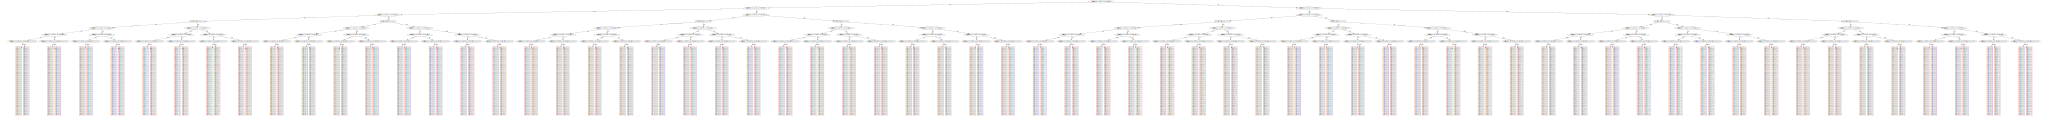

<Figure size 576x288 with 0 Axes>

In [93]:
plt.figure(figsize=(8,4))
cl_cat.plot_tree(tree_idx=1, pool =pool)

In [94]:
print(confusion_matrix(y_test, y_pred_catpool))

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 9 ... 0 0 0]
 ...
 [0 0 0 ... 5 0 0]
 [0 0 0 ... 0 7 0]
 [0 0 0 ... 0 0 6]]


In [95]:
print(metrics.classification_report(y_test, y_pred_catpool))

                                 precision    recall  f1-score   support

                            art       0.00      0.00      0.00         2
          arts_and_craftmanship       0.00      0.00      0.00         1
                           auto       1.00      1.00      1.00         9
                           baby       1.00      1.00      1.00         4
                 bed_bath_table       1.00      1.00      1.00         7
         books_general_interest       1.00      0.50      0.67         2
                books_technical       1.00      1.00      1.00         2
                     cine_photo       0.00      0.00      0.00         0
          computers_accessories       1.00      1.00      1.00         9
                 consoles_games       1.00      1.00      1.00         3
construction_tools_construction       1.00      1.00      1.00         2
      construction_tools_lights       1.00      1.00      1.00         2
      construction_tools_safety       1.00      1.

# Frequent Pattern Growth Algorithm  

FPGROWTH is an improvement to the Apriori method. A frequent pattern is generated without the need for candidate generation. 
FP growth algorithm represents the database in the form of a tree called a frequent pattern tree or FP tree.

This tree structure will maintain the association between the itemsets. 
The database is fragmented using one frequent item. This fragmented part is called “pattern fragment”. 
The itemsets of these fragmented patterns are analyzed. 
With this method, the search for frequent itemsets is reduced comparatively.

In [96]:
# Apply frequent pattern growth algorithm to data with min support threshold of 0.00001 and a two-item limit.
frequent_itemsets_fp = fpgrowth(onehot_encoded, min_support = 0.00001, max_len = 2, use_colnames=True)

# Print frequent itemsets.
frequent_itemsets_fp

support                                           itemsets
0    0.037345                                       (cool_stuff)
1    0.017582                                         (pet_shop)
2    0.066310                                  (furniture_decor)
3    0.032512                                        (perfumery)
4    0.036173                                     (garden_tools)
..        ...                                                ...
308  0.000010          (fashion_bags_accessories, fashion_sport)
309  0.000010            (fashio_female_clothing, fashion_sport)
310  0.000010                                 (la_cuisine, baby)
311  0.000010                         (la_cuisine, garden_tools)
312  0.000021  (fashion_bags_accessories, fashion_childrens_c...

[313 rows x 2 columns]

In [97]:
# Recover association rules using support and a minimum threshold of 0.00001 for fpgrowth
rules_fp = association_rules(frequent_itemsets_fp, metric = 'support', min_threshold = 0.00001)

# Print rules header.
rules_fp

antecedents                  consequents  \
0                   (cool_stuff)             (sports_leisure)   
1               (sports_leisure)                 (cool_stuff)   
2                   (cool_stuff)                  (telephony)   
3                    (telephony)                 (cool_stuff)   
4                   (cool_stuff)            (furniture_decor)   
..                           ...                          ...   
479                       (baby)                 (la_cuisine)   
480                 (la_cuisine)               (garden_tools)   
481               (garden_tools)                 (la_cuisine)   
482   (fashion_bags_accessories)  (fashion_childrens_clothes)   
483  (fashion_childrens_clothes)   (fashion_bags_accessories)   

     antecedent support  consequent support   support  confidence       lift  \
0              0.037345            0.079378  0.000010    0.000275   0.003469   
1              0.079378            0.037345  0.000010    0.000130   0.003469   
2              0.037345            0.043175  0.000062    0.001652   0.038263   
3              0.043175            0.037345  0.000062    0.001429   0.038263   
4              0.037345            0.066310  0.000041    0.001101   0.016609   
..                  ...                 ...       ...         ...        ...   
479            0.029664            0.000134  0.000010    0.000347   2.593148   
480            0.000134            0.036173  0.000010    0.076923   2.126558   
481            0.036173            0.000134  0.000010    0.000284   2.126558   
482            0.019166            0.000082  0.000021    0.001073  13.043991   
483            0.000082            0.019166  0.000021    0.250000  13.043991   

     leverage  conviction  
0   -0.002954    0.920875  
1   -0.002954    0.962780  
2   -0.001551    0.958409  
3   -0.001551    0.964033  
4   -0.002435    0.934720  
..        ...         ...  
479  0.000006    1.000213  
480  0.000005    1.044146  
481  0.000005    1.000151  
482  0.000019    1.000992  
483  0.000019    1.307779  

[484 rows x 9 columns]

Pruning association rules

In [98]:
# Recover association rules for fpgrowth using support and a minimum threshold of 0.00005
rules_fp = association_rules(frequent_itemsets_fp, metric = 'confidence', min_threshold = 0.00005)

# Print rules header.
rules_fp

antecedents                  consequents  \
0                   (cool_stuff)             (sports_leisure)   
1               (sports_leisure)                 (cool_stuff)   
2                   (cool_stuff)                  (telephony)   
3                    (telephony)                 (cool_stuff)   
4                   (cool_stuff)            (furniture_decor)   
..                           ...                          ...   
479                       (baby)                 (la_cuisine)   
480                 (la_cuisine)               (garden_tools)   
481               (garden_tools)                 (la_cuisine)   
482   (fashion_bags_accessories)  (fashion_childrens_clothes)   
483  (fashion_childrens_clothes)   (fashion_bags_accessories)   

     antecedent support  consequent support   support  confidence       lift  \
0              0.037345            0.079378  0.000010    0.000275   0.003469   
1              0.079378            0.037345  0.000010    0.000130   0.003469   
2              0.037345            0.043175  0.000062    0.001652   0.038263   
3              0.043175            0.037345  0.000062    0.001429   0.038263   
4              0.037345            0.066310  0.000041    0.001101   0.016609   
..                  ...                 ...       ...         ...        ...   
479            0.029664            0.000134  0.000010    0.000347   2.593148   
480            0.000134            0.036173  0.000010    0.076923   2.126558   
481            0.036173            0.000134  0.000010    0.000284   2.126558   
482            0.019166            0.000082  0.000021    0.001073  13.043991   
483            0.000082            0.019166  0.000021    0.250000  13.043991   

     leverage  conviction  
0   -0.002954    0.920875  
1   -0.002954    0.962780  
2   -0.001551    0.958409  
3   -0.001551    0.964033  
4   -0.002435    0.934720  
..        ...         ...  
479  0.000006    1.000213  
480  0.000005    1.044146  
481  0.000005    1.000151  
482  0.000019    1.000992  
483  0.000019    1.307779  

[484 rows x 9 columns]

# Visualizing patterns in metrics and comparing the output of apriori and fpgrowth algorithm

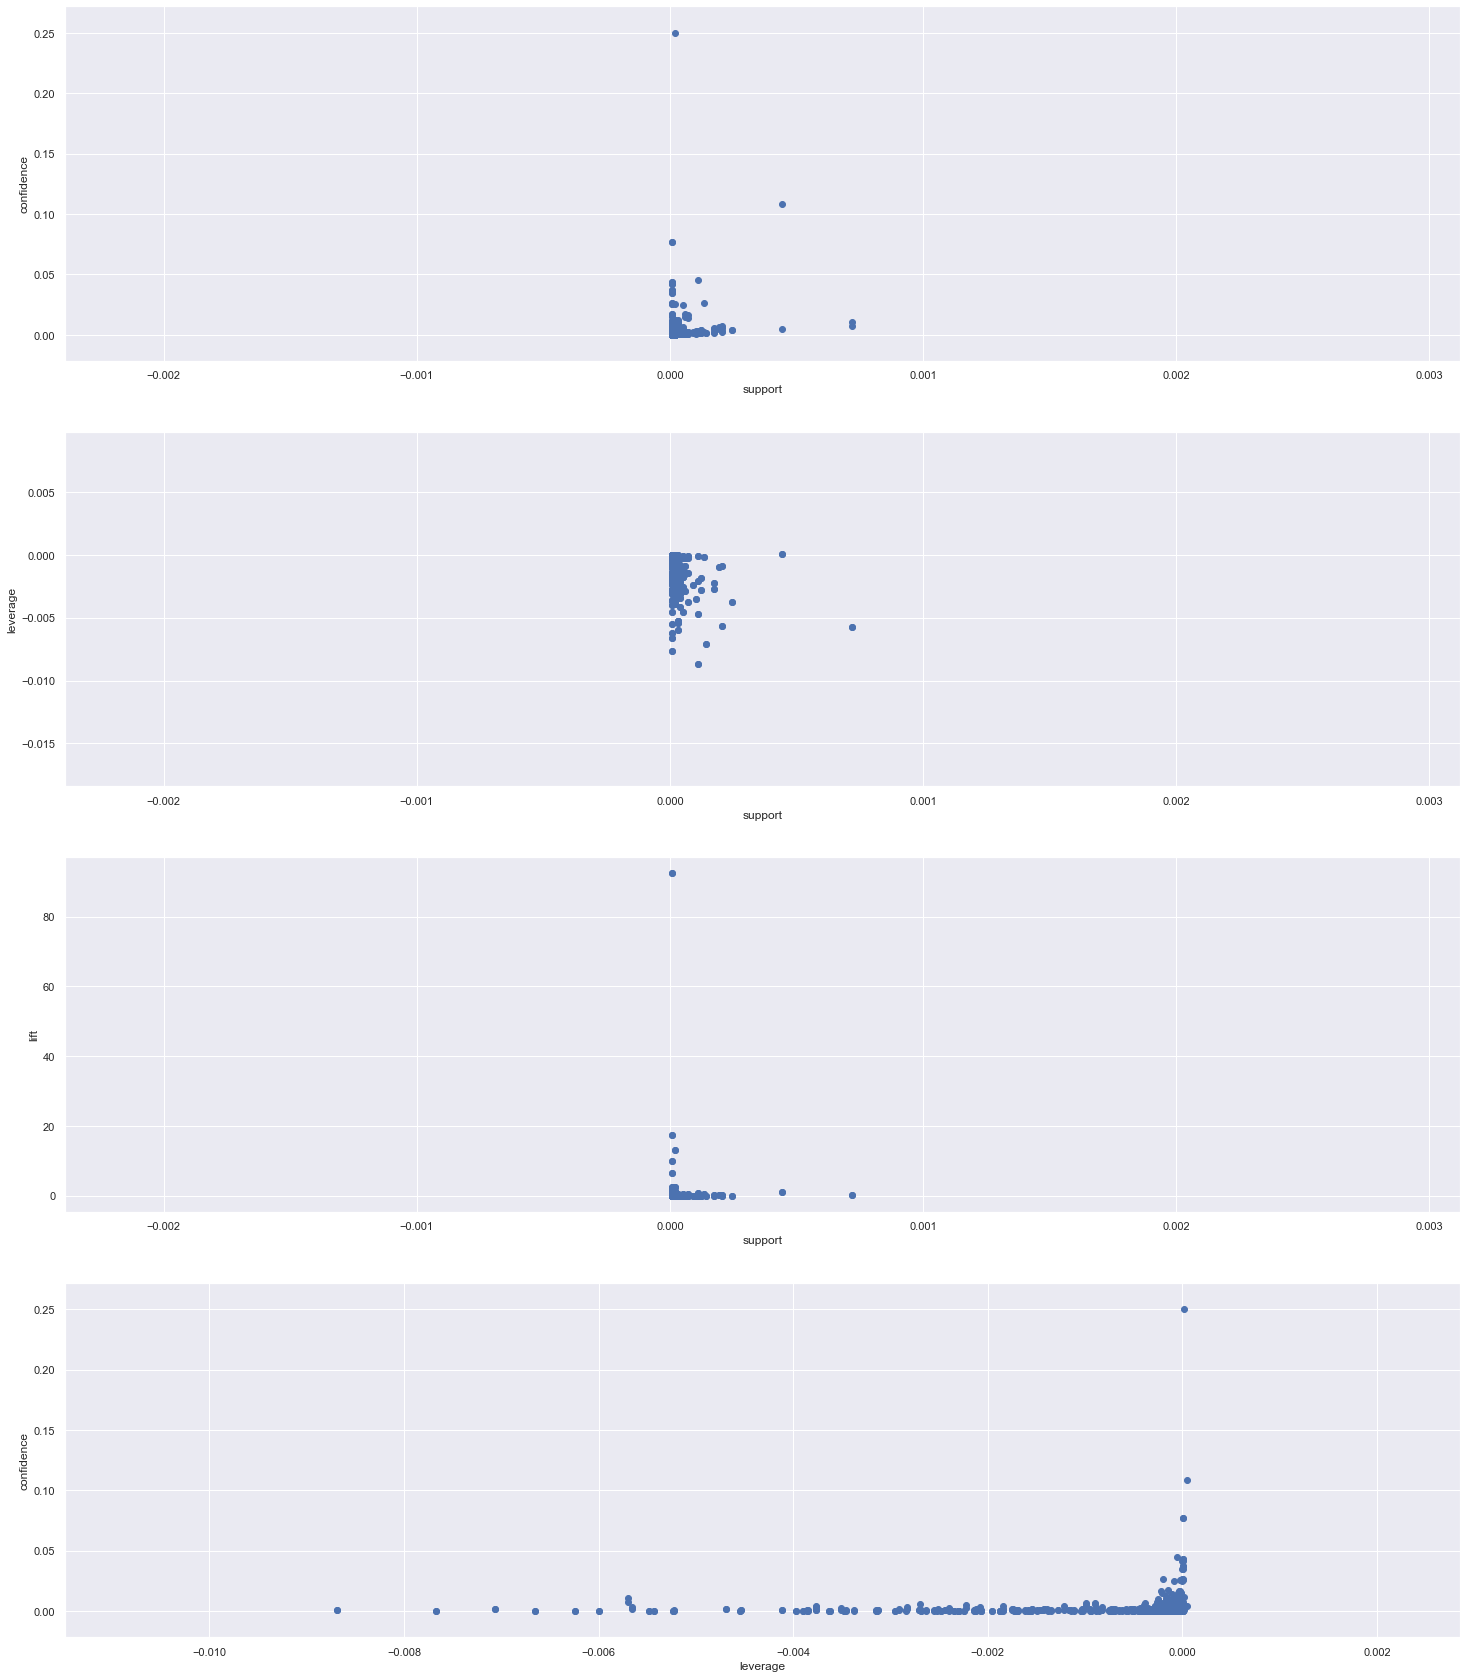

In [99]:
fig, ax = plt.subplots(4, figsize=(25, 30))
ax[0].scatter(x = rules['support'], y = rules['confidence'])
ax[0].set_xlabel("support")
ax[0].set_ylabel("confidence")

ax[1].scatter(x = rules['support'], y = rules['leverage'])
ax[1].set_xlabel("support")
ax[1].set_ylabel("leverage")

ax[2].scatter(x = rules['support'], y = rules['lift'])
ax[2].set_xlabel("support")
ax[2].set_ylabel("lift")

ax[3].scatter(x = rules['leverage'], y = rules['confidence'])
ax[3].set_xlabel("leverage")
ax[3].set_ylabel("confidence")

plt.show()

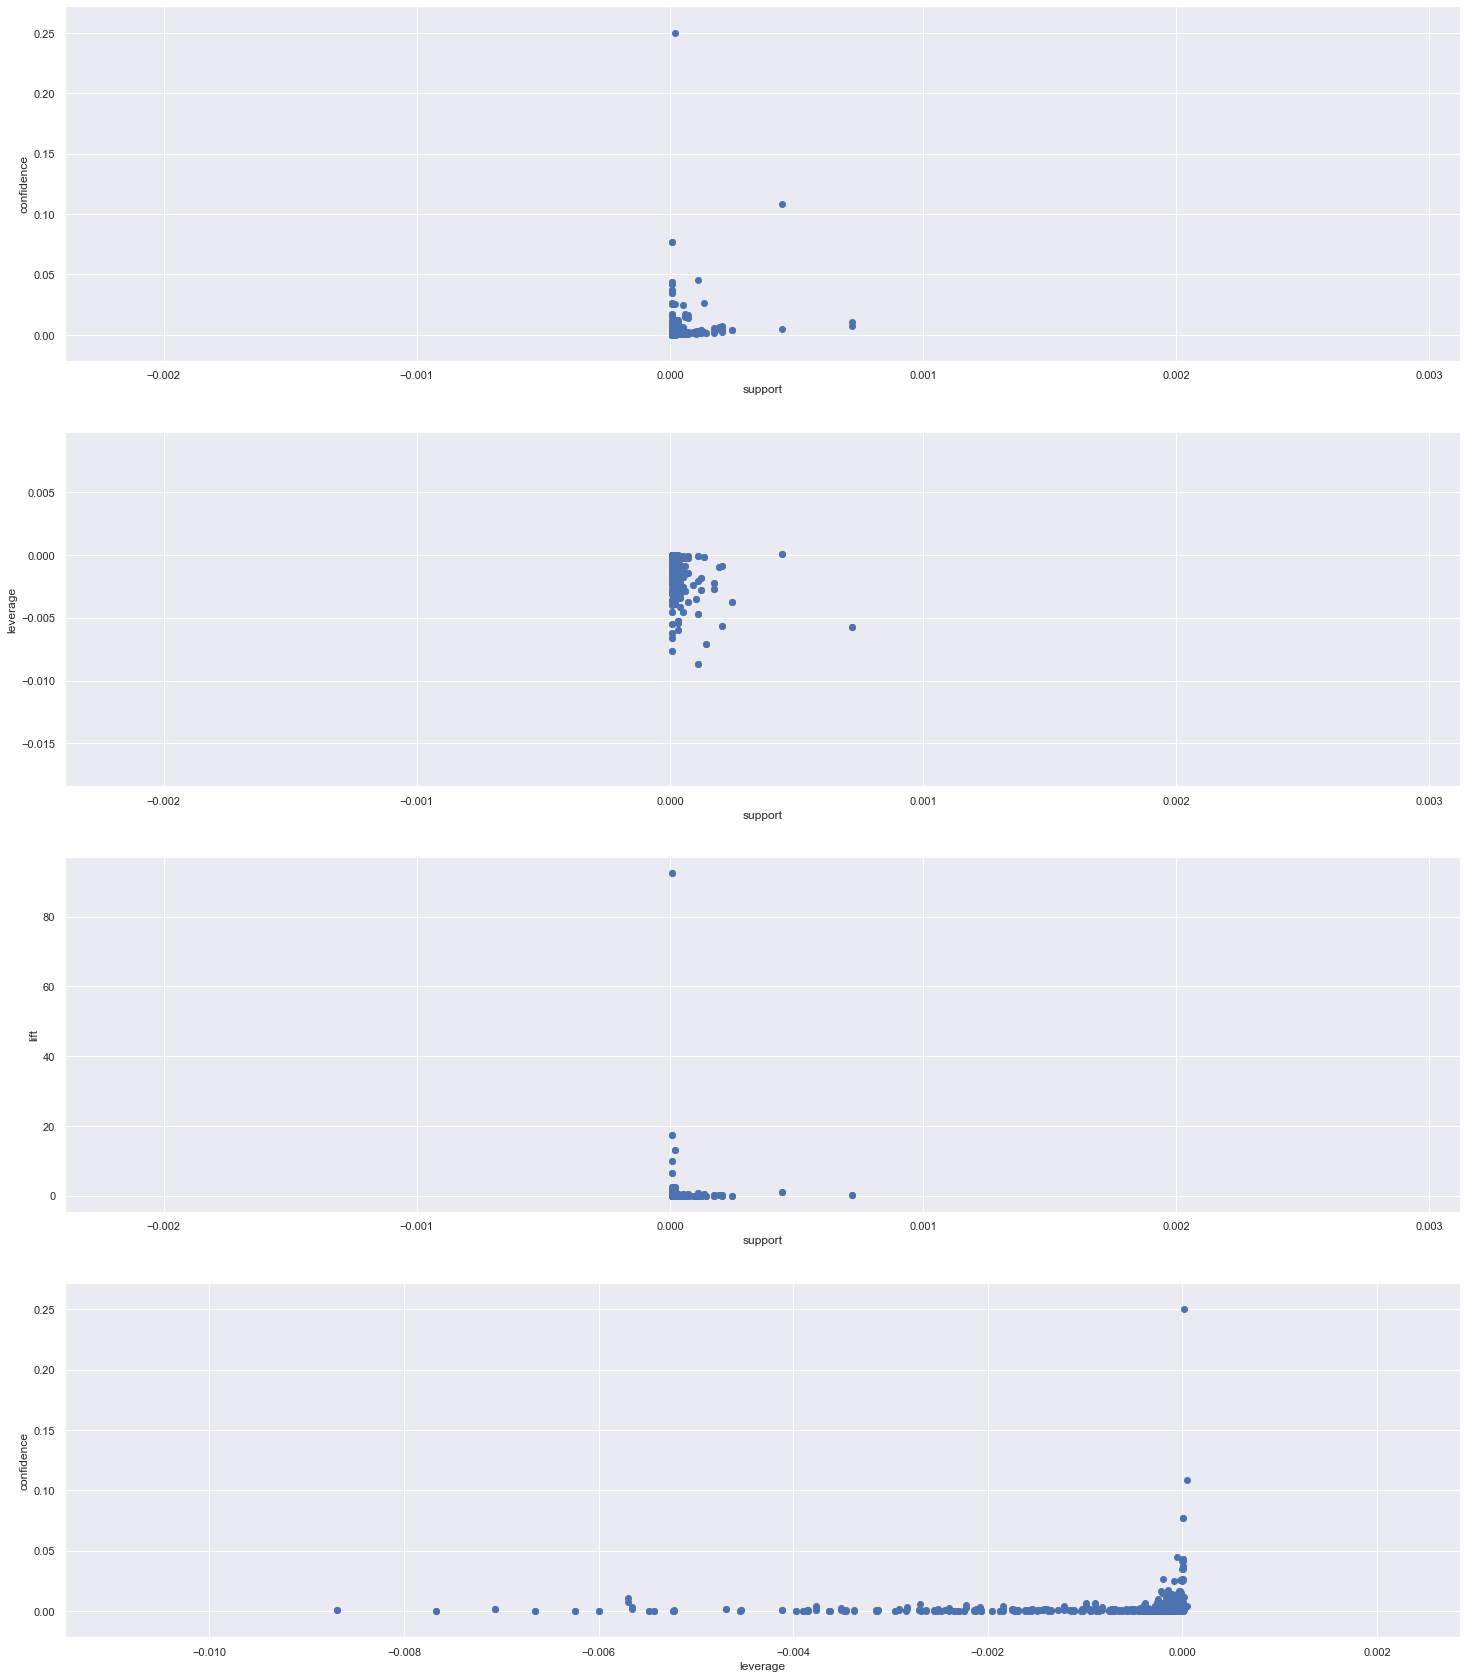

In [100]:
fig, ax = plt.subplots(4, figsize=(25, 30))
ax[0].scatter(x = rules_fp['support'], y = rules_fp['confidence'])
ax[0].set_xlabel("support")
ax[0].set_ylabel("confidence")

ax[1].scatter(x = rules_fp['support'], y = rules_fp['leverage'])
ax[1].set_xlabel("support")
ax[1].set_ylabel("leverage")

ax[2].scatter(x = rules_fp['support'], y = rules_fp['lift'])
ax[2].set_xlabel("support")
ax[2].set_ylabel("lift")

ax[3].scatter(x = rules_fp['leverage'], y = rules_fp['confidence'])
ax[3].set_xlabel("leverage")
ax[3].set_ylabel("confidence")

plt.show()

In [101]:
from pandas.plotting import scatter_matrix

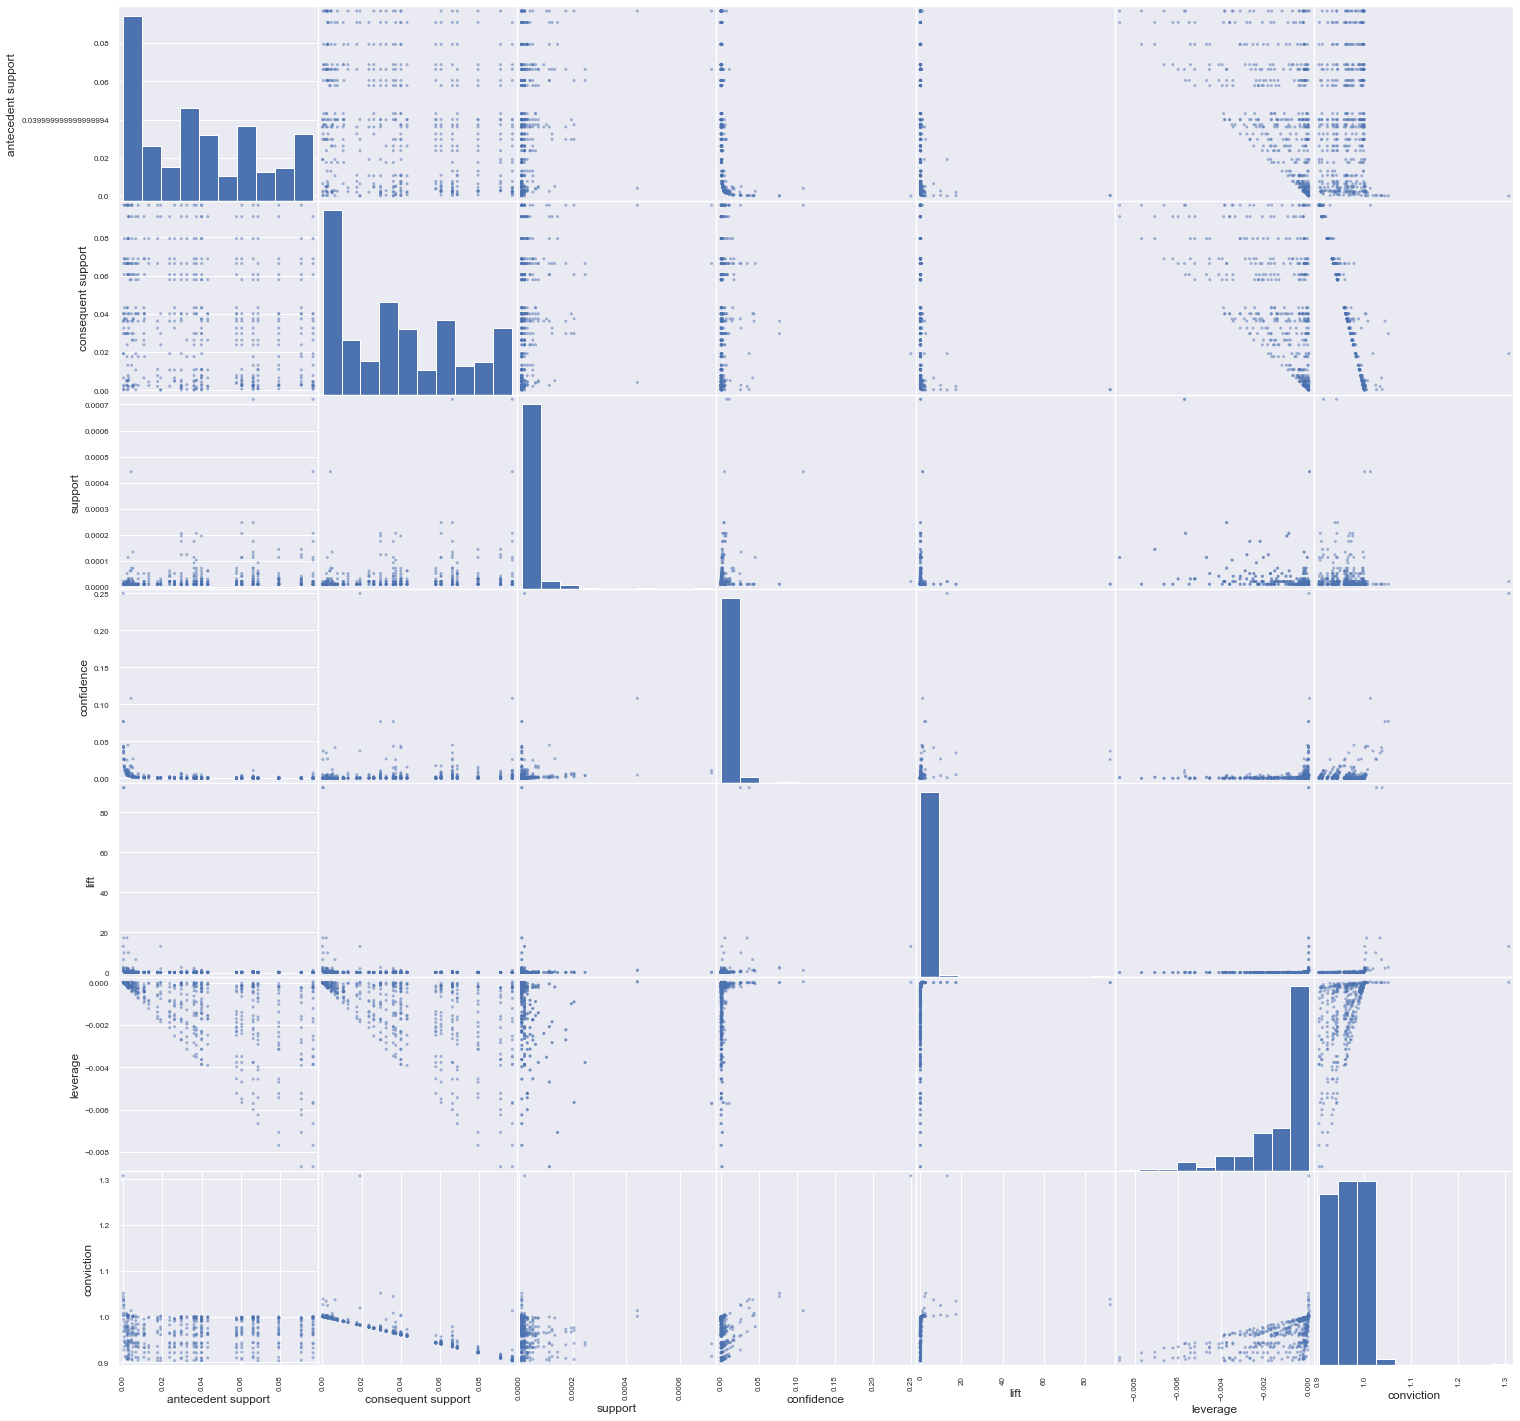

In [102]:
scatter_matrix(rules, figsize=(25,25))
plt.show()

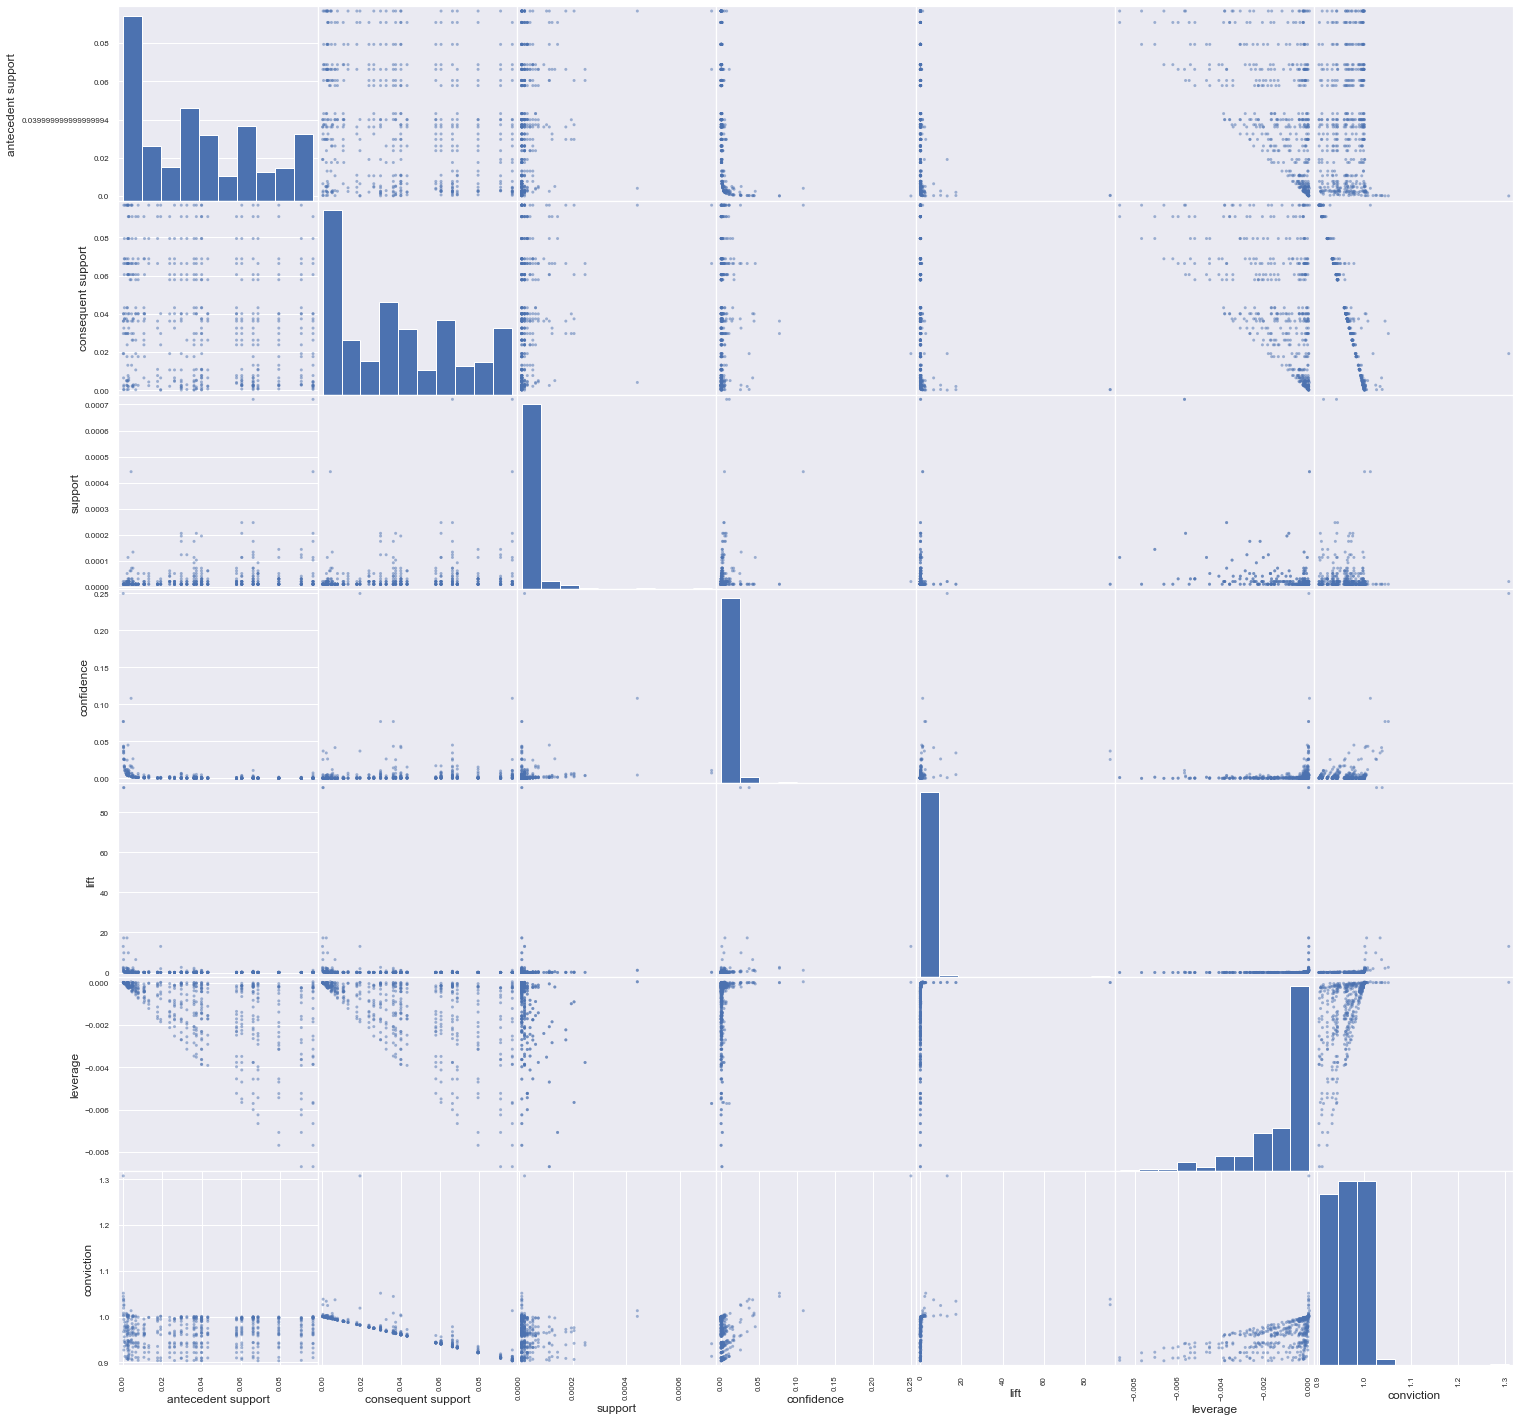

In [103]:
scatter_matrix(rules_fp, figsize=(25,25))
plt.show()

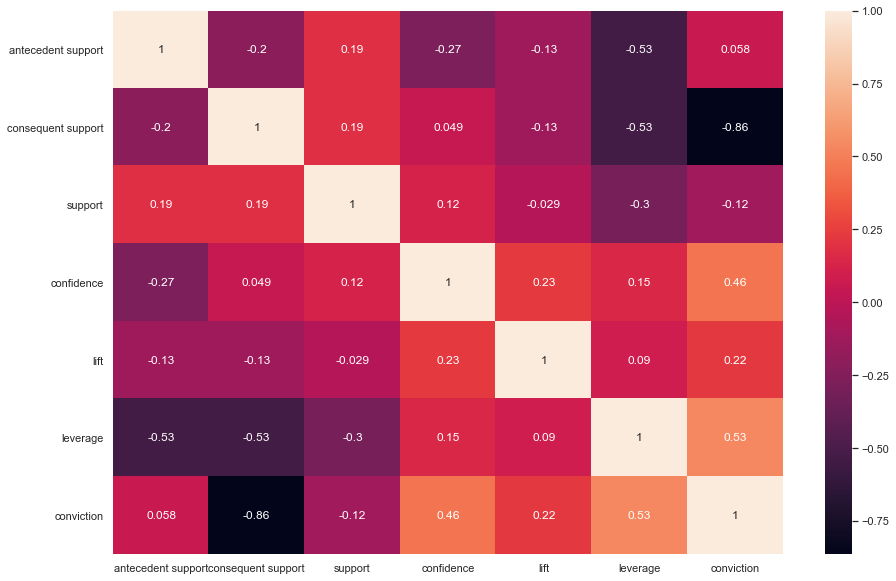

In [104]:
plt.figure(figsize=(15, 10))
sns.heatmap(rules.corr(), annot=True)

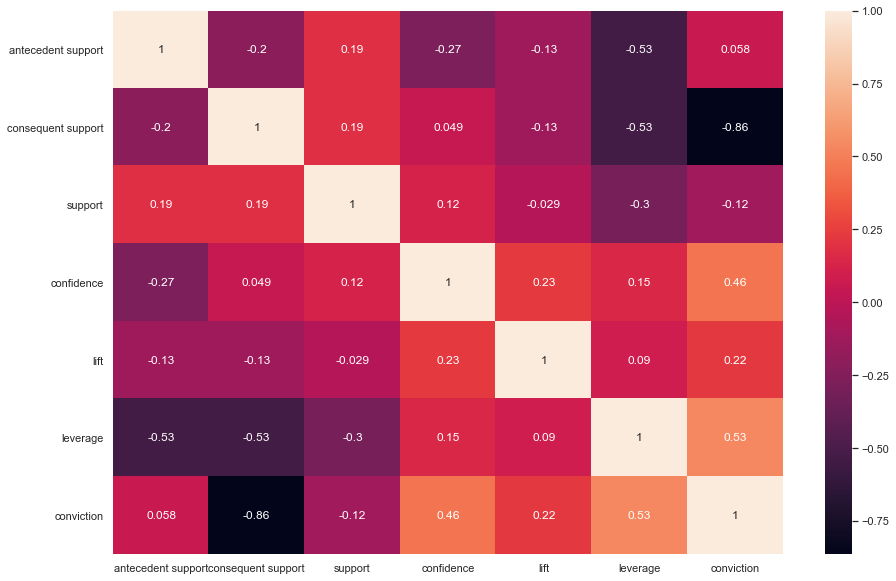

In [105]:
plt.figure(figsize=(15, 10))
sns.heatmap(rules_fp.corr(), annot=True)

# Save and load the models

In [106]:
import pickle

In [107]:
filename='catboost_model.sav'

In [108]:
pickle.dump(cl_cat, open(filename, 'wb'))

In [109]:
load_lr_model =pickle.load(open(filename, 'rb'))

In [110]:
score = load_lr_model.score(X_test, y_test)
print("Test score: {0:.2f} %".format(100 * score))

Test score: 95.88 %


In [111]:
y_load_pred = load_lr_model.predict(X_test)
print("accuracy: ",accuracy_score(y_test,y_load_pred))

accuracy:  0.9588235294117647
